## 0. Instalar pacotes

In [1]:
#!pip install category_encoders

## 1. Importar bibliotecas

In [2]:
import math
import datetime
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib        as mpl
import pandas            as pd
import seaborn           as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from category_encoders import TargetEncoder
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, ShuffleSplit
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, \
HistGradientBoostingClassifier,StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, f1_score, make_scorer, accuracy_score, precision_score, recall_score, auc
import pickle
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.feature_selection import VarianceThreshold
import random
import gc
# Definindo a semente
random.seed(123)

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


## Leitura dos Dados

In [3]:
df_publico = pd.read_csv('/content/tb_crm_clientes.csv')
df_publico.head()

,IDCliente,AnoDeNascimento,NivelDeEducacao,EstadoCivil,RendaAnualFamiliar,QtdDeCriancasNaCasa,QtdDeAdolescentesNaCasa,DataDeInscricao,DiasDesdeUltimaCompra,GastoComVinhoNosUltimos2Anos,...,VisitasAoSiteNoUltimoMes,AceitouCampanha3,AceitouCampanha4,AceitouCampanha5,AceitouCampanha1,AceitouCampanha2,ReclamouNosUltimos2Anos,IndicadorCustoContato,IndicadorDeReceita,AceitouUltimaCampanha
0,5524,1957,Graduação,Solteiro(a),58138.0,0,0,2021-04-09,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduação,Solteiro(a),46344.0,1,1,2023-08-03,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduação,União Estável,71613.0,0,0,2022-08-21,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduação,União Estável,26646.0,1,0,2023-10-02,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,Doutorado,Casado(a),58293.0,1,0,2023-01-19,94,173,...,5,0,0,0,0,0,0,3,11,0


In [4]:
X = df_publico.drop(columns='IDCliente')

# Separar atributos categóricos e numéricos
cat_attributes = X.select_dtypes(include='object')
num_attributes = X.select_dtypes(exclude='object')

# Copiar os nomes das colunas categóricas
vars1 = list(cat_attributes.columns).copy()

# Remover a coluna 'DataDeInscricao' da lista de variáveis categóricas
vars_categoricas = [var for var in vars1 if var != 'DataDeInscricao']

# Definir as variáveis numéricas excluindo variáveis categóricas, 'IDCliente' e 'AceitouUltimaCampanha'
vars_numericas = list(set(df_publico.columns) - set(vars_categoricas) - set(['IDCliente', 'AceitouUltimaCampanha', 'DataDeInscricao']))


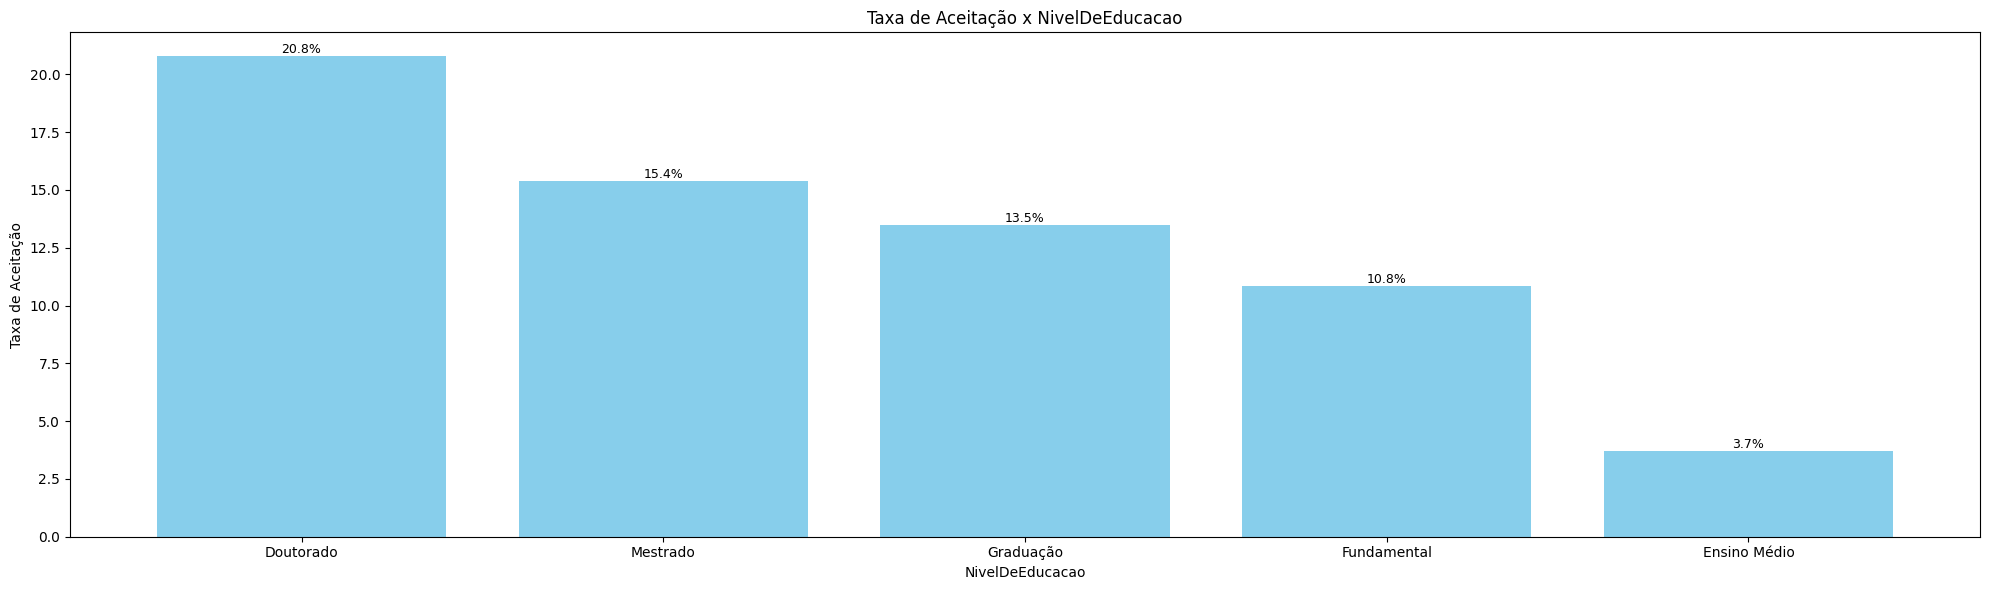

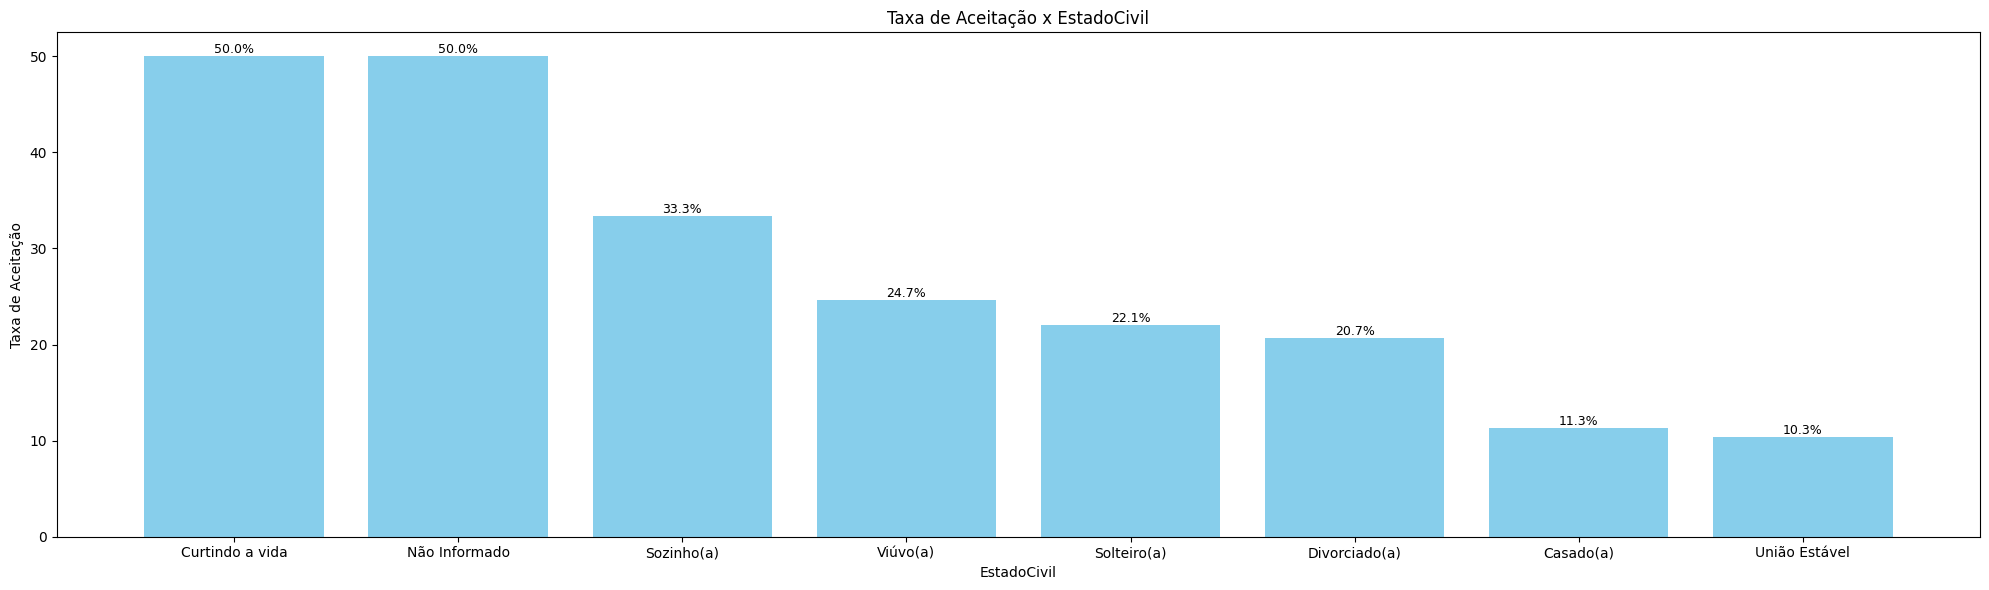

In [5]:
# Variáveis a serem analisadas:
for var in vars_categoricas:

  percentual_por_categoria = df_publico.groupby(var)['AceitouUltimaCampanha'].mean() * 100

  percentual_por_categoria = percentual_por_categoria.sort_values(ascending=False)

  plt.figure(figsize=(20, 6))
  bars = plt.bar(percentual_por_categoria.index, percentual_por_categoria.values, color='skyblue')

  for bar in bars:
      height = bar.get_height()
      plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.1f}%', ha='center', va='bottom', fontsize=9)

  plt.title(f'Taxa de Aceitação x {var}')
  plt.xlabel(f'{var}')
  plt.ylabel('Taxa de Aceitação')
  plt.tight_layout()
  plt.show()

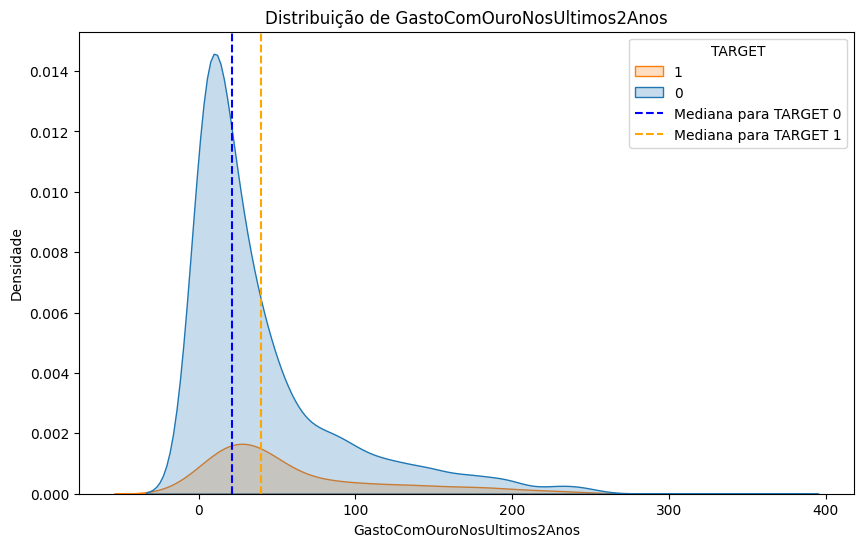

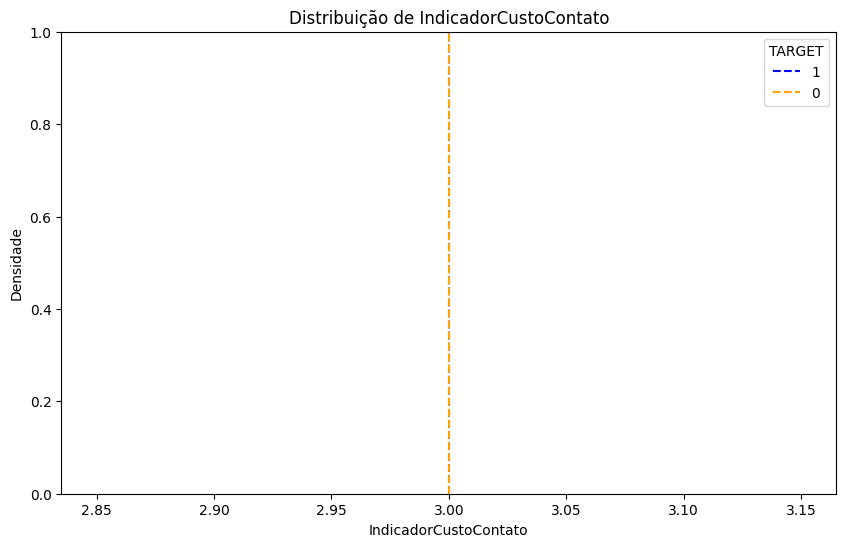

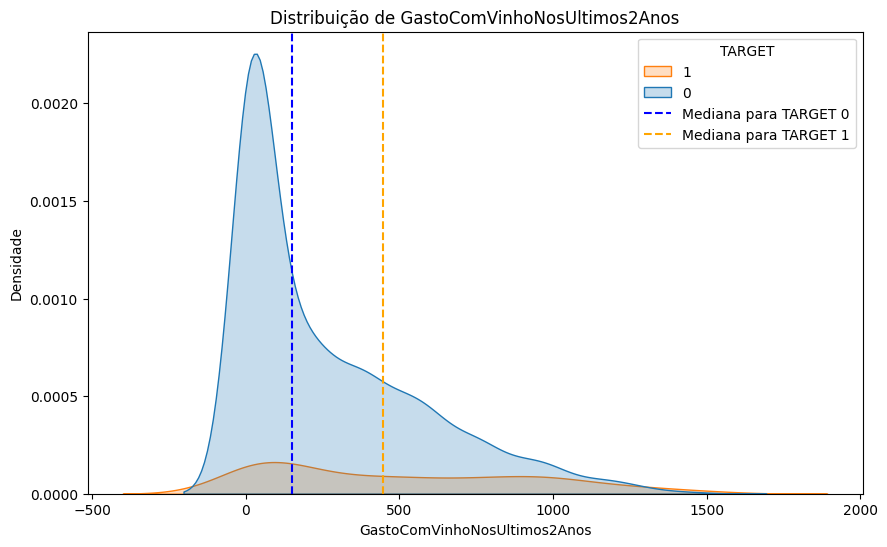

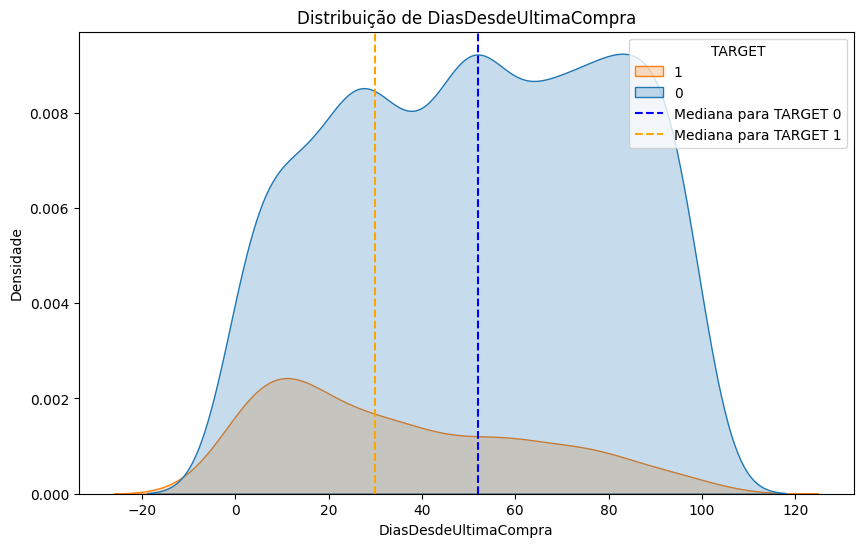

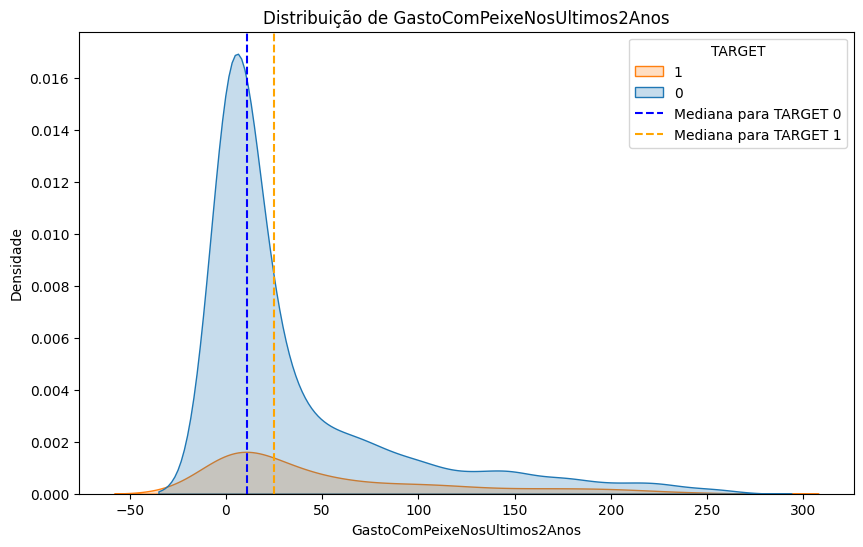

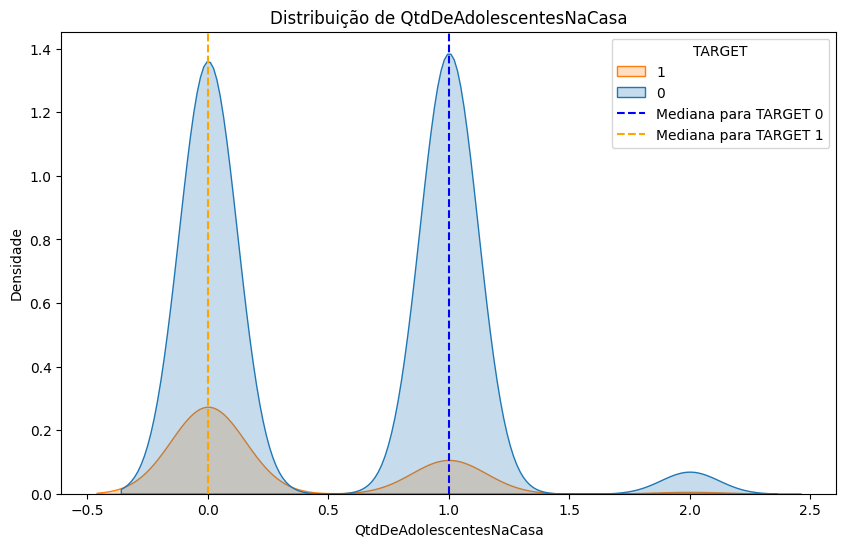

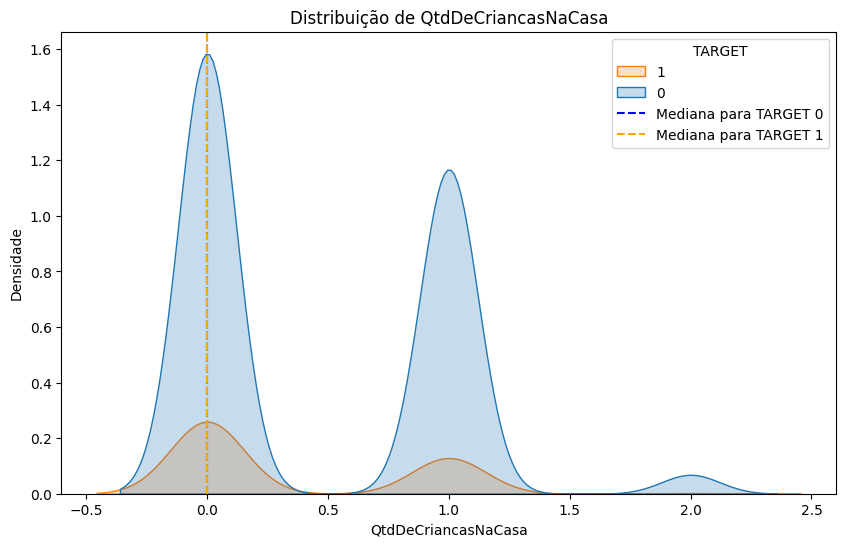

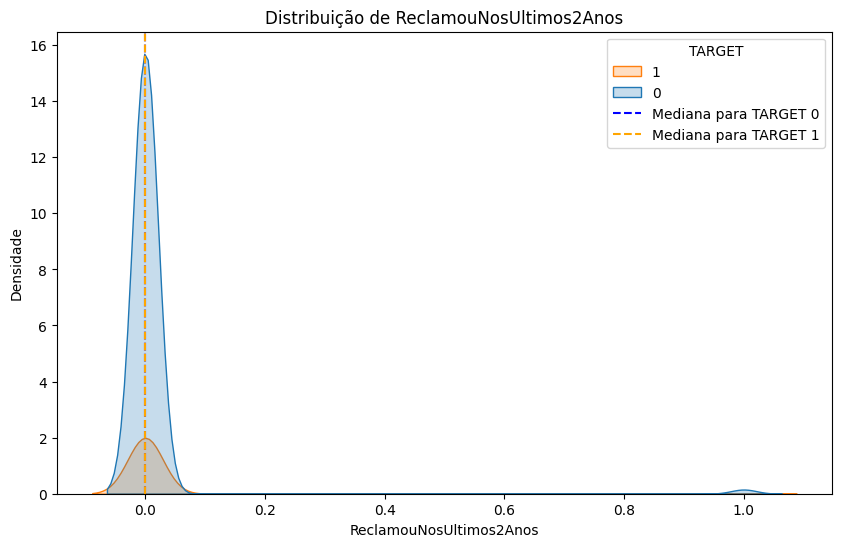

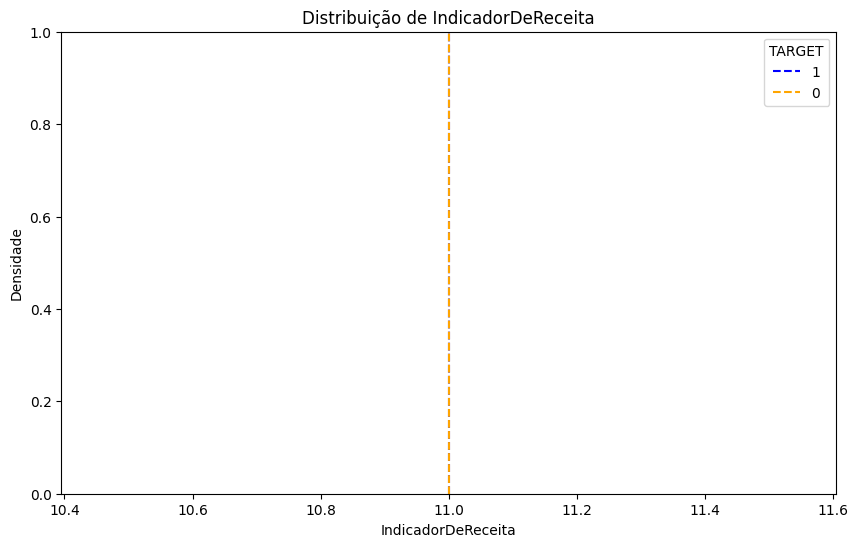

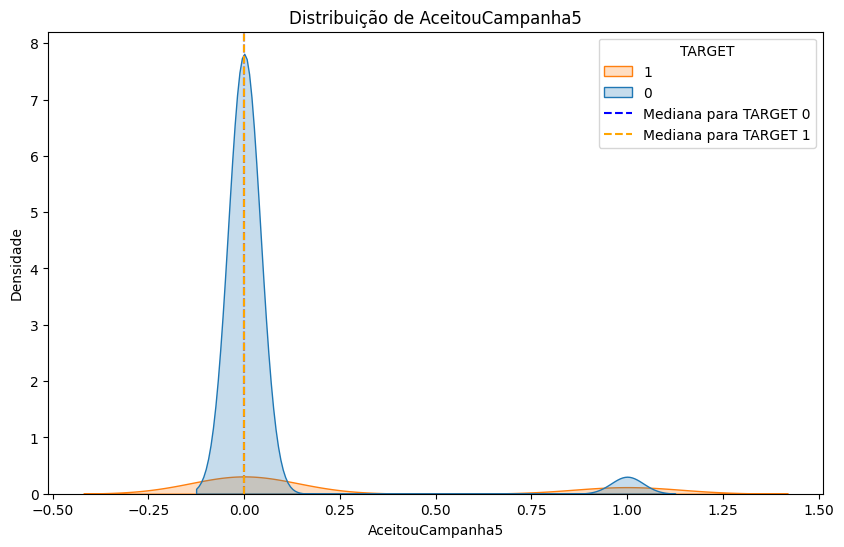

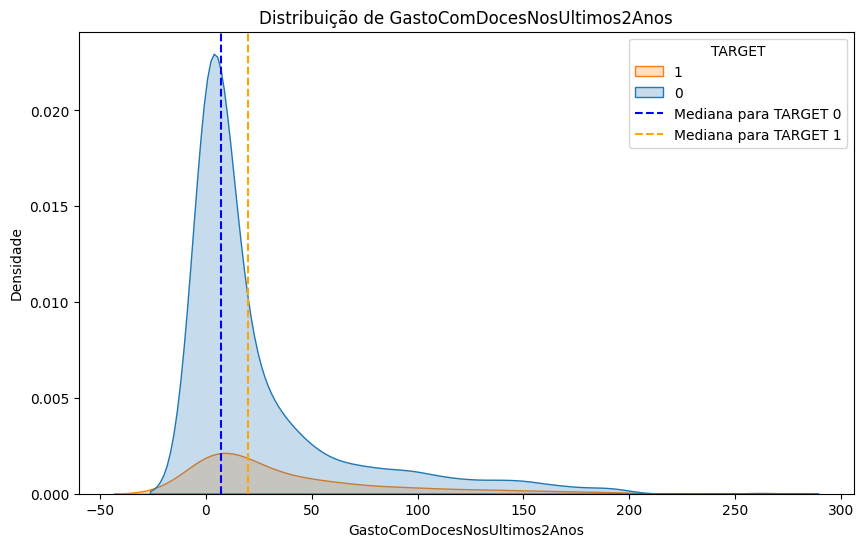

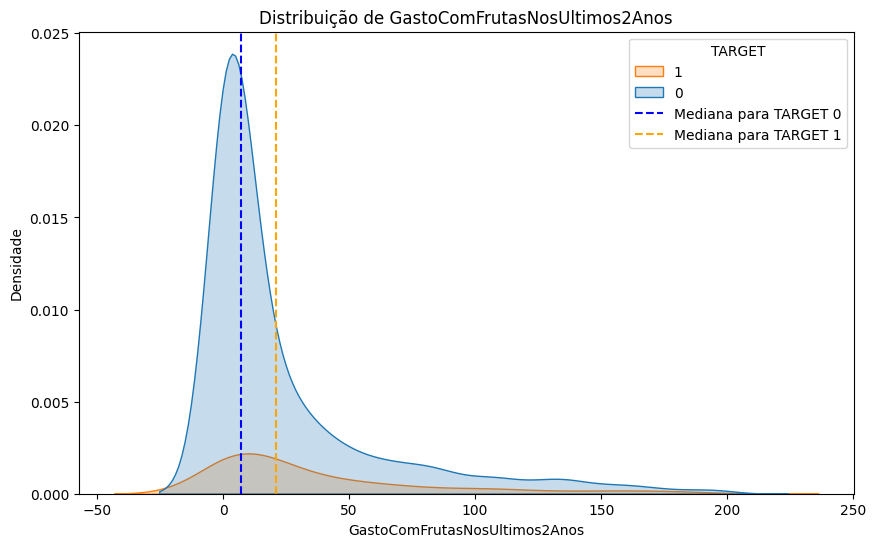

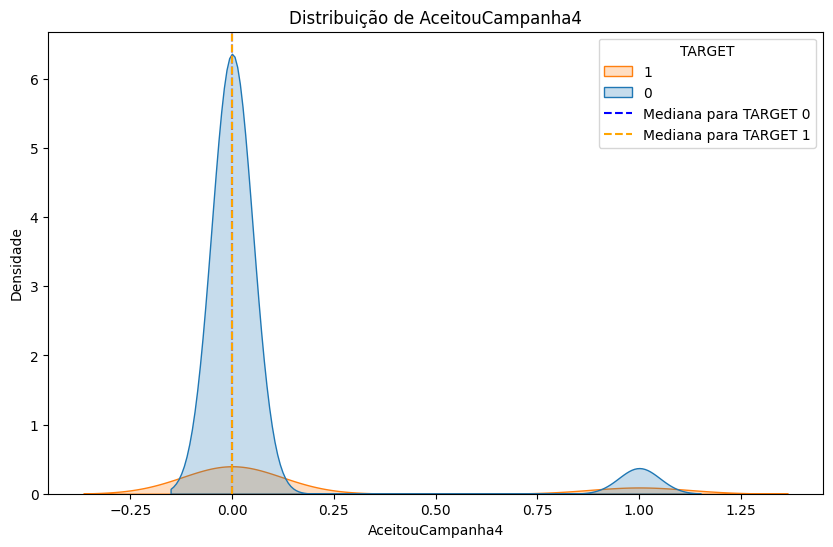

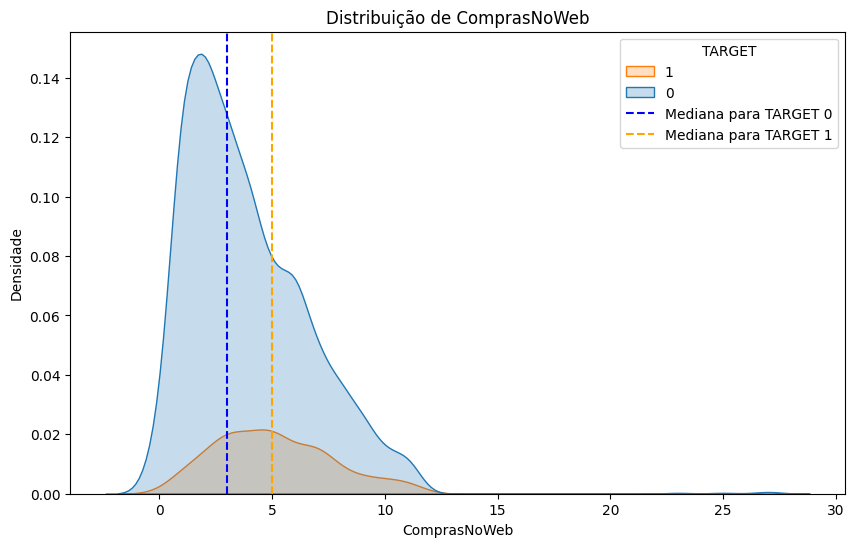

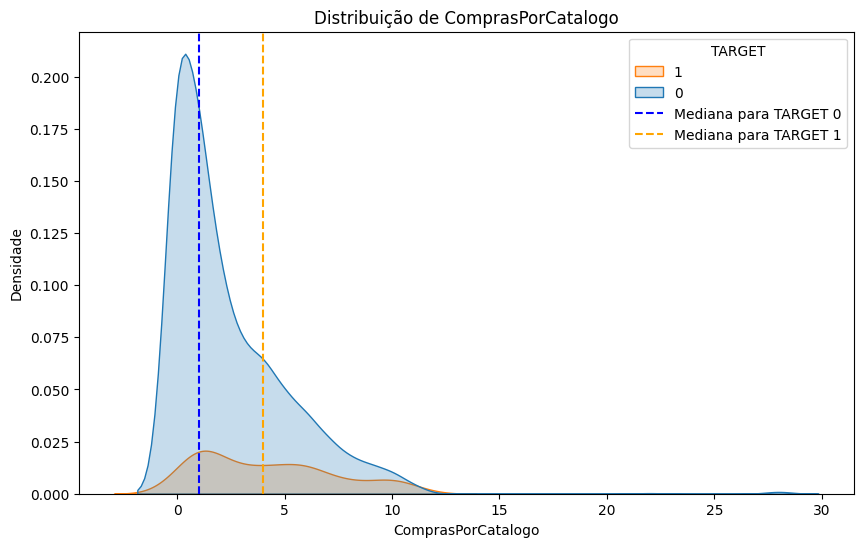

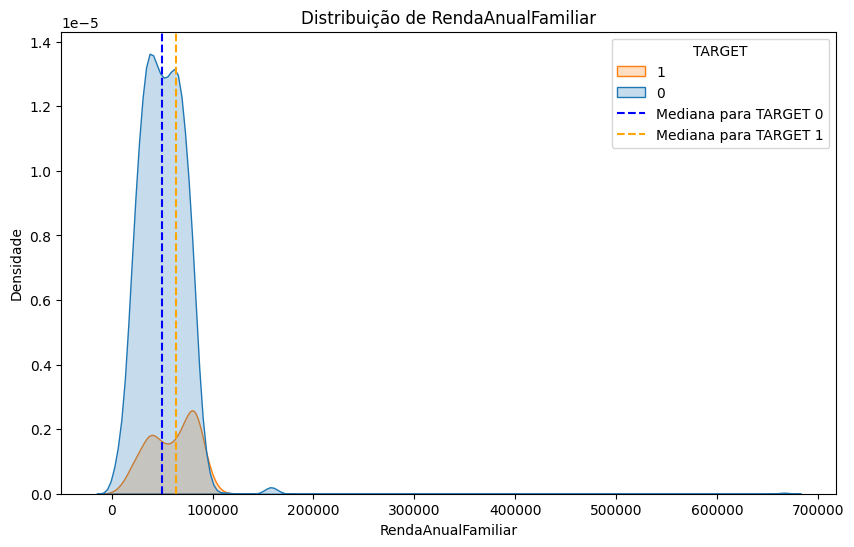

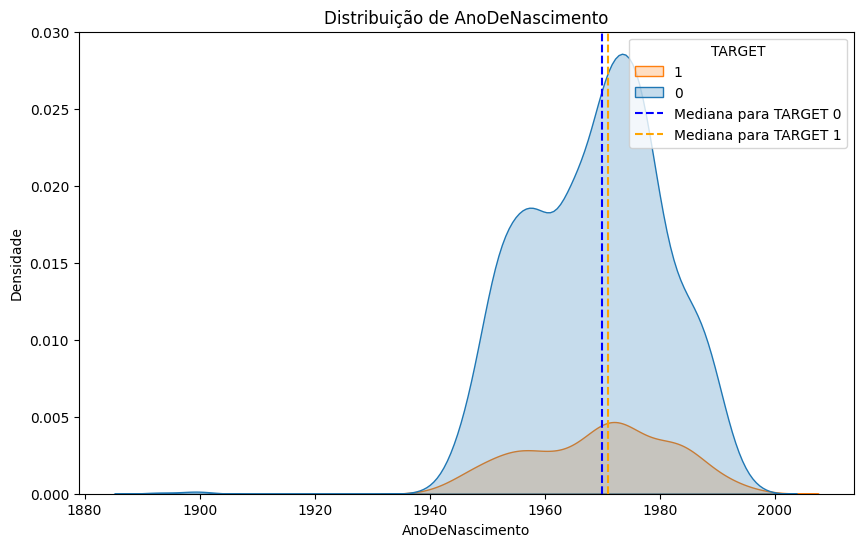

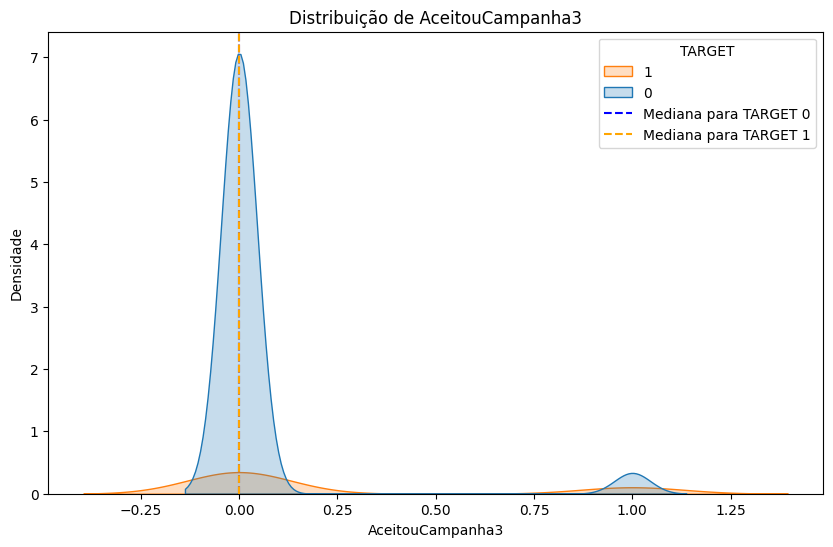

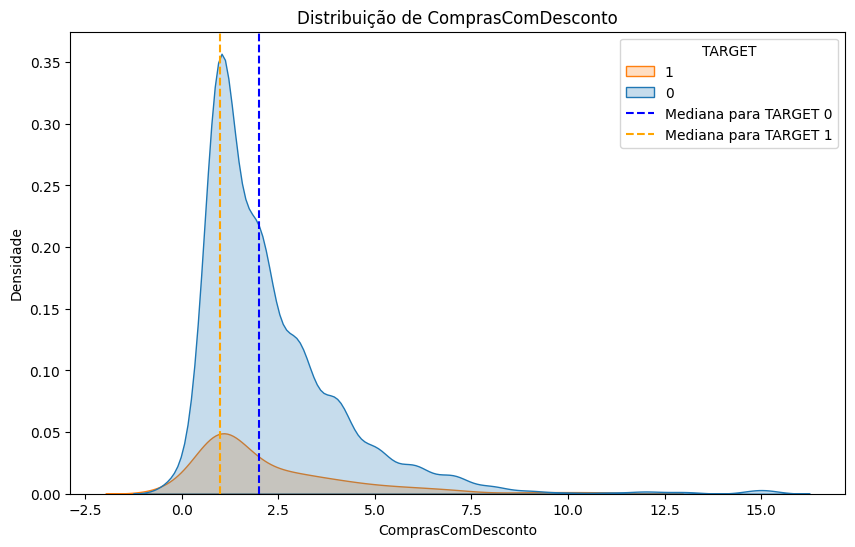

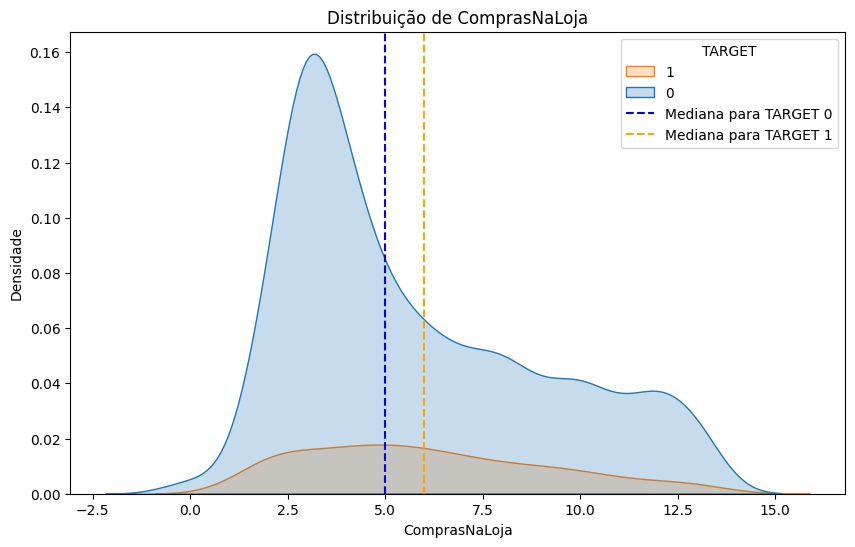

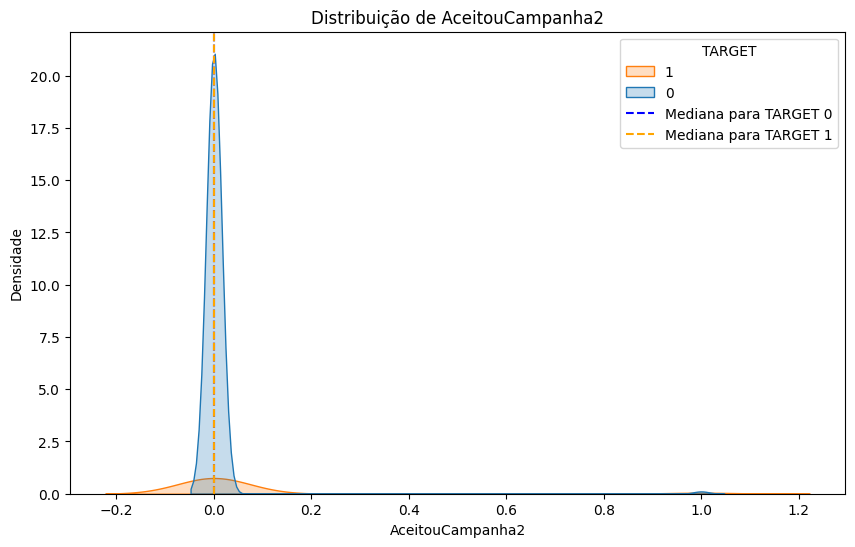

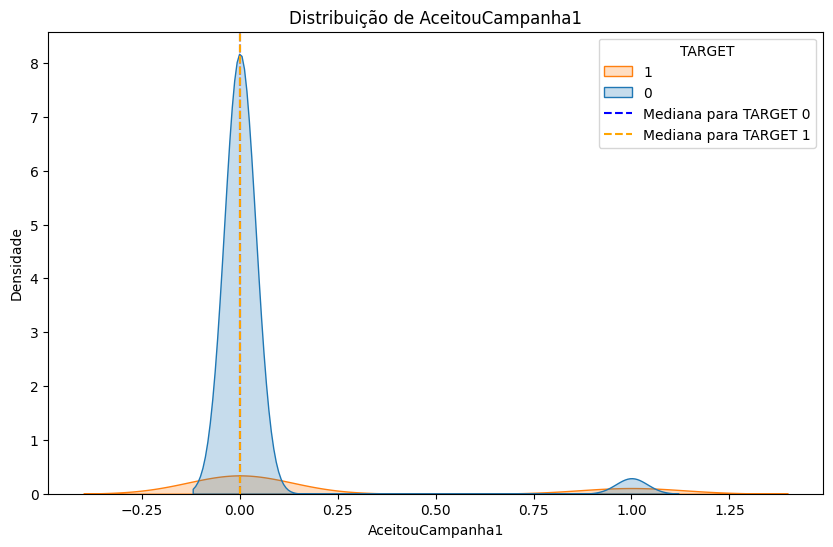

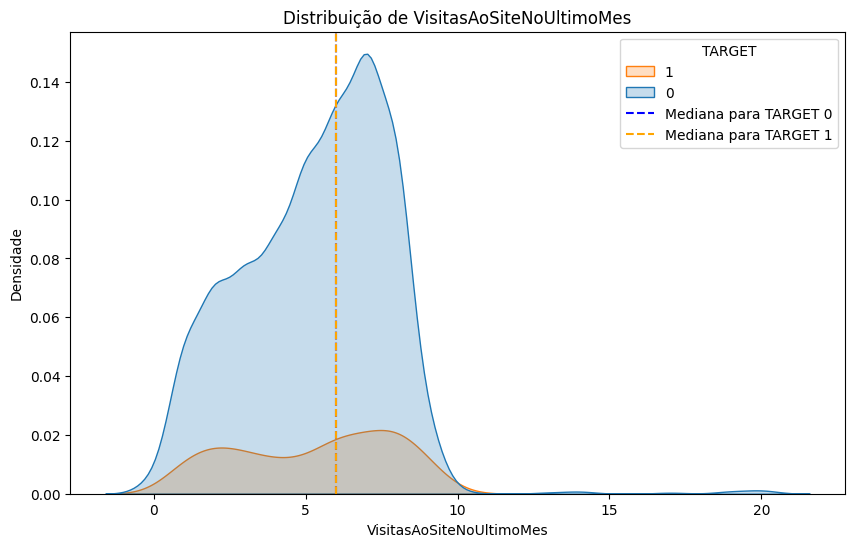

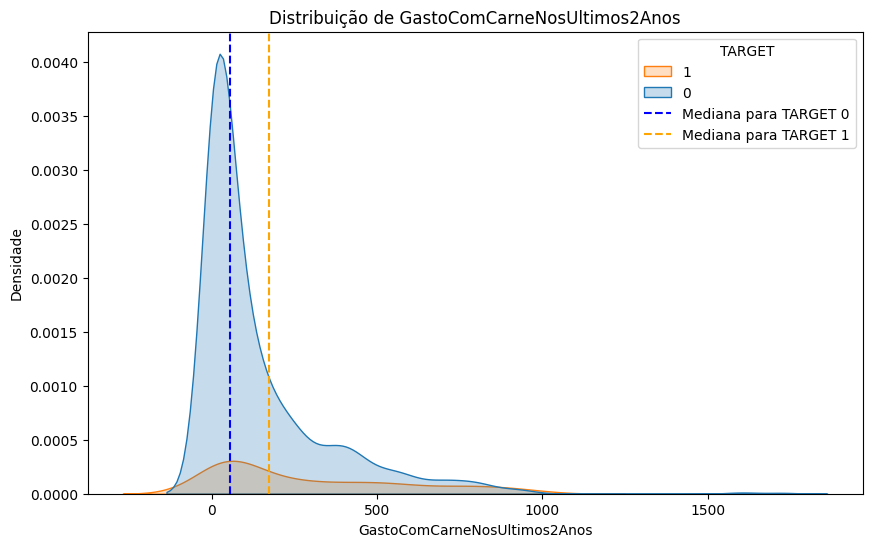

In [6]:
for var in vars_numericas:

  # Calcular as medianas para cada grupo
  medianas = df_publico.groupby('AceitouUltimaCampanha')[var].median()

  colors = ['blue','orange']
  i = 0

  plt.figure(figsize=(10, 6))
  sns.kdeplot(data=df_publico, x=var, hue='AceitouUltimaCampanha', fill=True, warn_singular=False)

  # Adicionar linhas verticais representando as medianas
  for target, mediana in medianas.items():
      plt.axvline(x=mediana, linestyle='--', color=colors[i], label=f'Mediana para TARGET {target}')
      i += 1

  plt.title(f'Distribuição de {var}')
  plt.ylabel('Densidade')
  plt.xlabel(f'{var}')
  plt.legend(title='TARGET', loc='upper right', labels=['1', '0', 'Mediana para TARGET 0', 'Mediana para TARGET 1'])
  plt.show()

# Obter a probabilidade de um cliente aceitar a campanha e com isso as variáveis que mais impactam a taxa de aceitação.

## Funções auxiliares


In [7]:
# Métricas do modelo

def calculate_metrics(nm_modelo, model, X_train, y_train, X_test, y_test):
    # Fazendo predições
    y_train_prob = (model.predict_proba(X_train))[:,1]
    y_test_prob = (model.predict_proba(X_test))[:,1]

    y_train_pred = (model.predict(X_train))
    y_test_pred = (model.predict(X_test))

    # Calculando as métricas para o conjunto de treino
    accuracy_train = accuracy_score(y_train, y_train_pred)
    precision_train = precision_score(y_train, y_train_pred)
    recall_train = recall_score(y_train, y_train_pred)
    auc_roc_train = roc_auc_score(y_train, np.array(y_train_prob))

    # Calculando o Índice Gini e Estatística KS para o conjunto de treino
    probabilities_train = np.array(y_train_prob)
    df_train = pd.DataFrame({'true_labels': y_train, 'predicted_probs': probabilities_train})
    df_train = df_train.sort_values(by='predicted_probs', ascending=False)
    df_train['cumulative_true'] = df_train['true_labels'].cumsum() / df_train['true_labels'].sum()
    df_train['cumulative_false'] = (1 - df_train['true_labels']).cumsum() / (1 - df_train['true_labels']).sum()
    ks_statistic_train = max(abs(df_train['cumulative_true'] - df_train['cumulative_false']))
    gini_index_train = 2 * auc_roc_train - 1

    # Calculando as métricas para o conjunto de teste
    accuracy_test = accuracy_score(y_test, y_test_pred)
    precision_test = precision_score(y_test, y_test_pred)
    recall_test = recall_score(y_test, y_test_pred)
    auc_roc_test = roc_auc_score(y_test, np.array(y_test_prob))

    # Calculando o Índice Gini e Estatística KS para o conjunto de teste
    probabilities_test = np.array(y_test_prob)
    df_test = pd.DataFrame({'true_labels': y_test, 'predicted_probs': probabilities_test})
    df_test = df_test.sort_values(by='predicted_probs', ascending=False)
    df_test['cumulative_true'] = df_test['true_labels'].cumsum() / df_test['true_labels'].sum()
    df_test['cumulative_false'] = (1 - df_test['true_labels']).cumsum() / (1 - df_test['true_labels']).sum()
    ks_statistic_test = max(abs(df_test['cumulative_true'] - df_test['cumulative_false']))
    gini_index_test = 2 * auc_roc_test - 1

    # Criando o DataFrame com as métricas calculadas
    metrics_df = pd.DataFrame({
        'Algoritmo': [nm_modelo, nm_modelo],
        'Conjunto': ['Treino', 'Teste'],
        'Acuracia': [accuracy_train, accuracy_test],
        'Precisao': [precision_train, precision_test],
        'Recall': [recall_train, recall_test],
        'AUC_ROC': [auc_roc_train, auc_roc_test],
        'GINI': [gini_index_train, gini_index_test],
        'KS': [ks_statistic_train, ks_statistic_test]
    })
    return metrics_df

# Metadados referente ao conjunto de dados
def pod_academy_generate_metadata(dataframe):
    """
    Gera um dataframe contendo metadados das colunas do dataframe fornecido.

    :param dataframe: DataFrame para o qual os metadados serão gerados.
    :return: DataFrame contendo metadados.
    """

    # Coleta de metadados básicos
    metadata = pd.DataFrame({
        'nome_variavel': dataframe.columns,
        'tipo': dataframe.dtypes,
        'qt_nulos': dataframe.isnull().sum(),
        'percent_nulos': round((dataframe.isnull().sum() / len(dataframe))* 100,2),
        'cardinalidade': dataframe.nunique(),
    })
    metadata=metadata.sort_values(by='percent_nulos',ascending=False)
    metadata = metadata.reset_index(drop=True)

    return metadata

In [8]:
abt = df_publico.drop(columns=['IDCliente', 'AceitouUltimaCampanha', 'DataDeInscricao'])
target = df_publico.AceitouUltimaCampanha

X_train, X_test, y_train, y_test = train_test_split(abt,target,test_size=0.20,random_state=0)

## Preparação dos dados e seleção de variáveis

In [9]:
# Imputar dados
from sklearn.impute import SimpleImputer

abt_treino = pd.concat((X_train,y_train),axis=1)
abt_test = pd.concat((X_test,y_test),axis=1)

imputer_num = SimpleImputer(strategy='median')
imputer_cat = SimpleImputer(strategy='most_frequent')

num_features_train = X_train[vars_numericas]
cat_features_train = X_train[vars_categoricas]

num_features_test = X_test[vars_numericas]
cat_features_test = X_test[vars_categoricas]

df1 = pd.DataFrame(imputer_num.fit_transform(num_features_train),columns=vars_numericas)
df2 = pd.DataFrame(imputer_num.transform(num_features_test),columns=vars_numericas)
df1.index = num_features_train.index
df2.index = num_features_test.index
num_features_train = df1.copy()
num_features_test = df2.copy()

df1 = pd.DataFrame(imputer_cat.fit_transform(cat_features_train),columns=vars_categoricas)
df2 = pd.DataFrame(imputer_cat.transform(cat_features_test),columns=vars_categoricas)
df1.index = cat_features_train.index
df2.index = cat_features_test.index
cat_features_train = df1.copy()
cat_features_test = df2.copy()

ce = TargetEncoder()

cat_features_train = ce.fit_transform(cat_features_train,y_train)
cat_features_test = ce.transform(cat_features_test,y_test)

new_abt_treino = pd.concat((num_features_train,cat_features_train),axis=1)
new_abt_teste = pd.concat((num_features_test,cat_features_test),axis=1)

# Remoção de variáveis com zero variância

selector = VarianceThreshold(threshold=0)
selector.fit_transform(new_abt_treino)

# Colunas selecionadas
selected_features = new_abt_treino.columns[selector.get_support()]

# Manter apenas features selecionadas
new_abt_treino = new_abt_treino[selected_features]
new_abt_teste = new_abt_teste[selected_features]

# Remoção de variáveis altamente correlacionadas

threshold = 0.875

# Calculate the correlation matrix
corr_matrix = new_abt_treino.corr().abs()

# Select the upper triangle of the correlation matrix
upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Identify columns to drop based on the threshold
to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > threshold)]

# Drop the columns
new_abt_treino = new_abt_treino.drop(columns=to_drop)
new_abt_teste = new_abt_teste.drop(columns=to_drop)

# new_abt_treino = pd.concat((new_abt_treino,y_train),axis=1)
# new_abt_teste = pd.concat((new_abt_teste,y_test),axis=1)

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.impute import SimpleImputer
import xgboost as xgb
import matplotlib.pyplot as plt

xgb_model = xgb.XGBClassifier(random_state=0)
# xgb_model.fit(new_abt_treino.drop(columns=['CODE_GENDER']), y_train)
xgb_model.fit(new_abt_treino, y_train)

# Obter a importância das features
feature_importance = xgb_model.feature_importances_

# df = pd.DataFrame({'Feature':new_abt_treino.drop(columns=['CODE_GENDER']).columns,'Importance':feature_importance})
df = pd.DataFrame({'Feature':new_abt_treino.columns,'Importance':feature_importance})

features_rl = df.sort_values(by='Importance',ascending=False)[:20].Feature.to_list()


X_train_03 = new_abt_treino[features_rl]
X_test_03 = new_abt_teste[features_rl]

new_abt_treino = pd.concat((X_train_03,y_train),axis=1)
new_abt_teste = pd.concat((X_test_03,y_test),axis=1)

## Verificar a linearidade com a log da odds

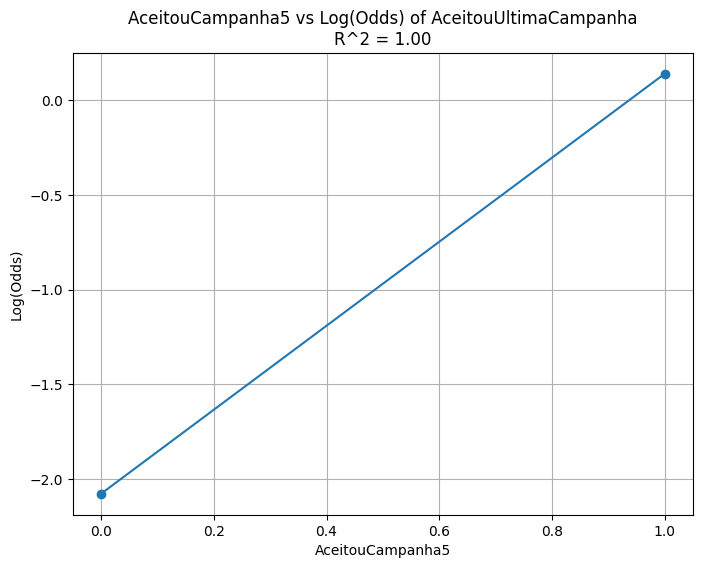

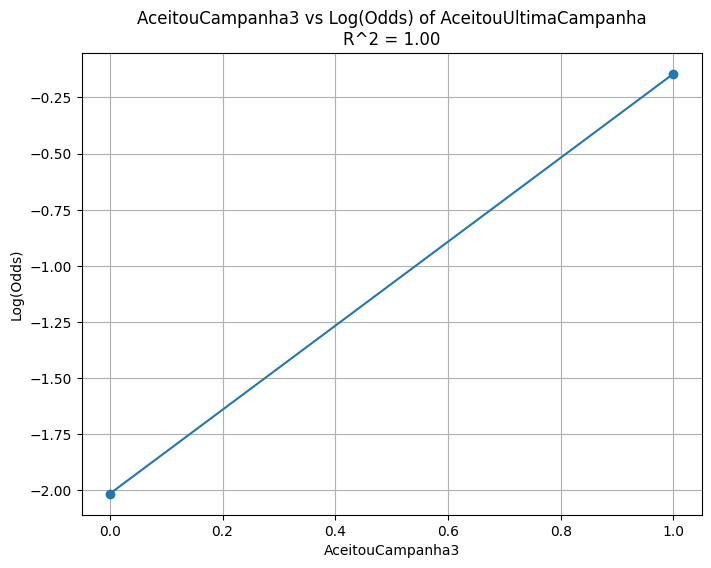

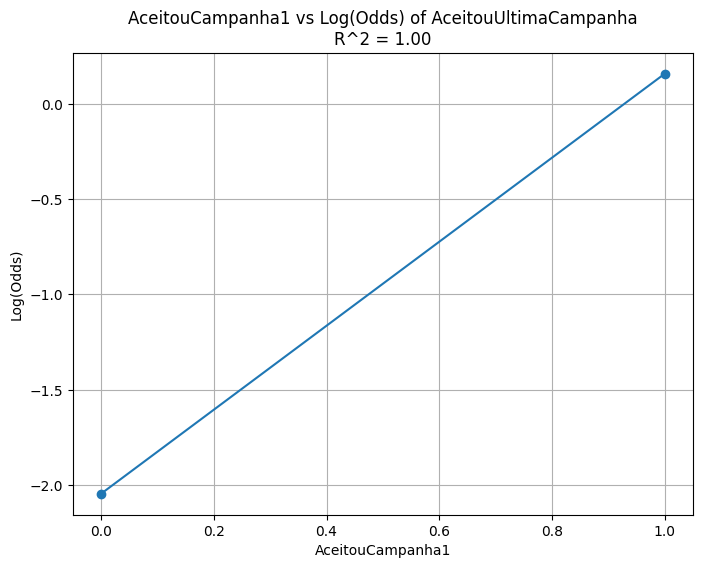

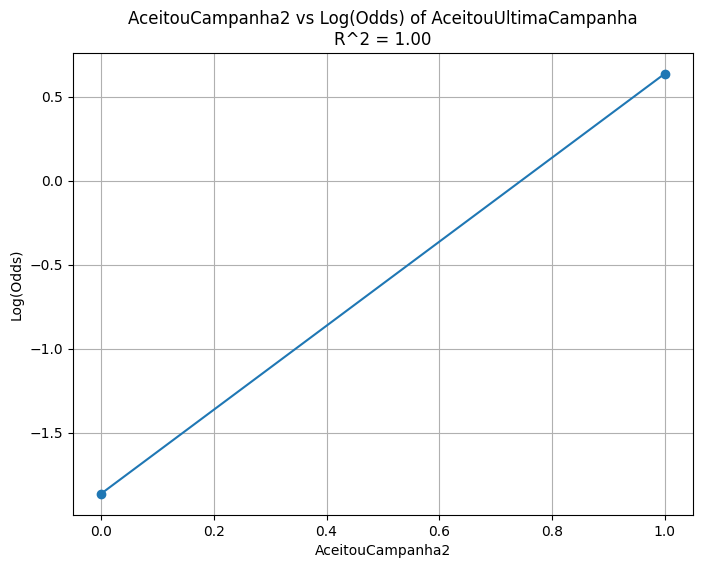

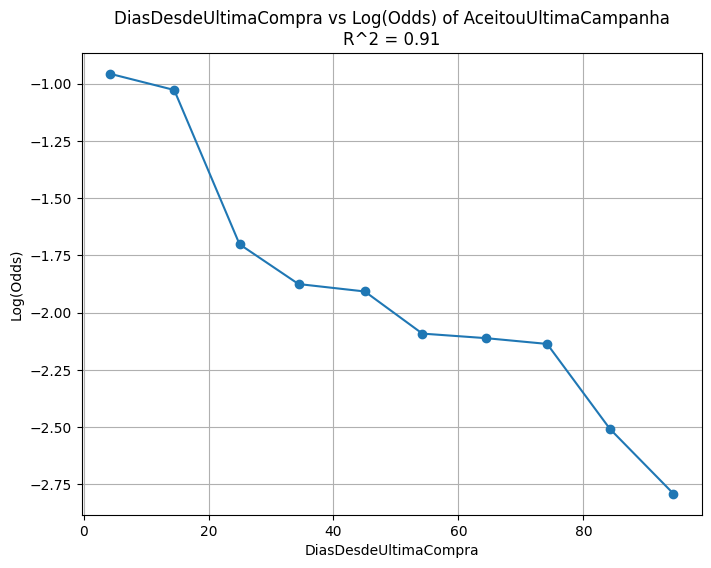

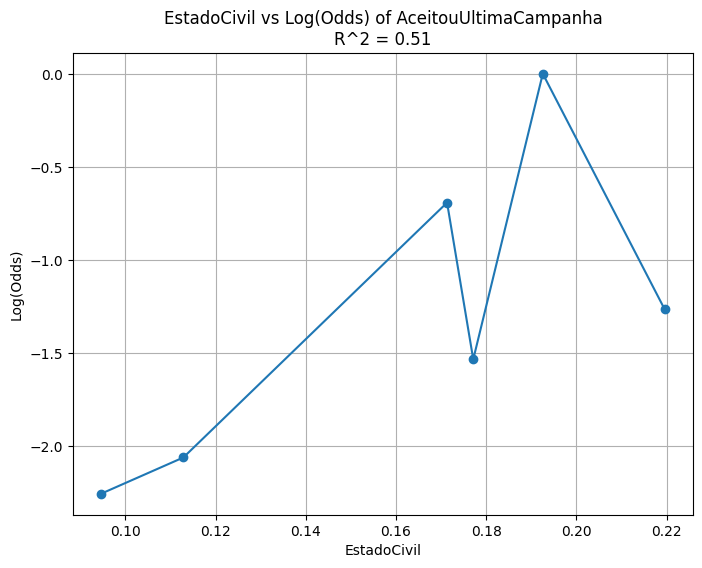

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


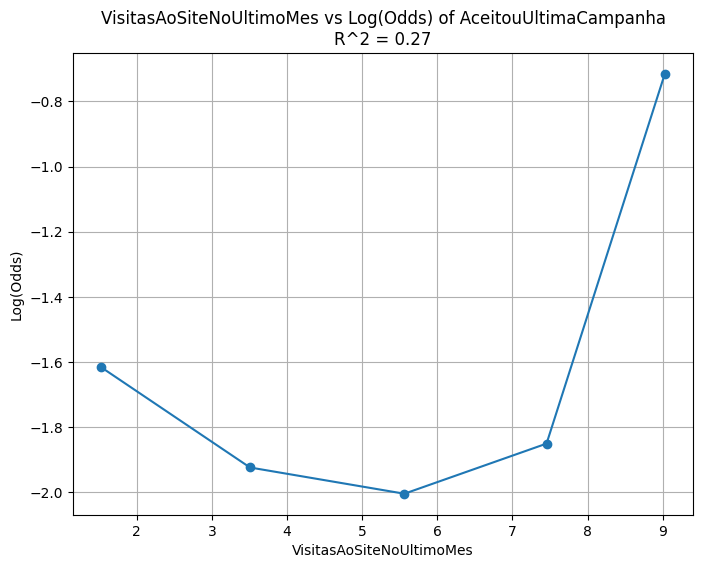

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


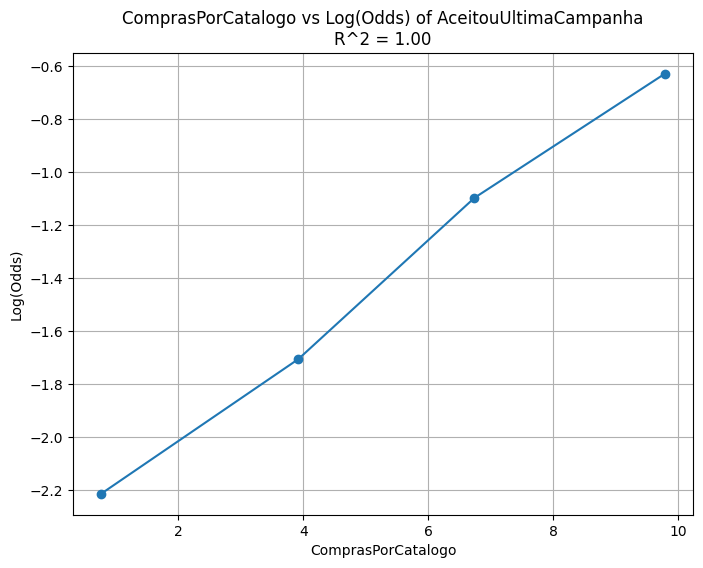

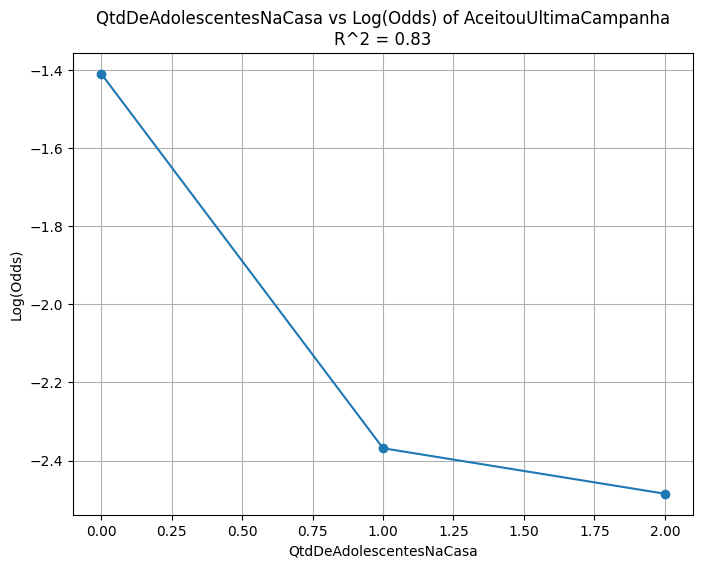

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


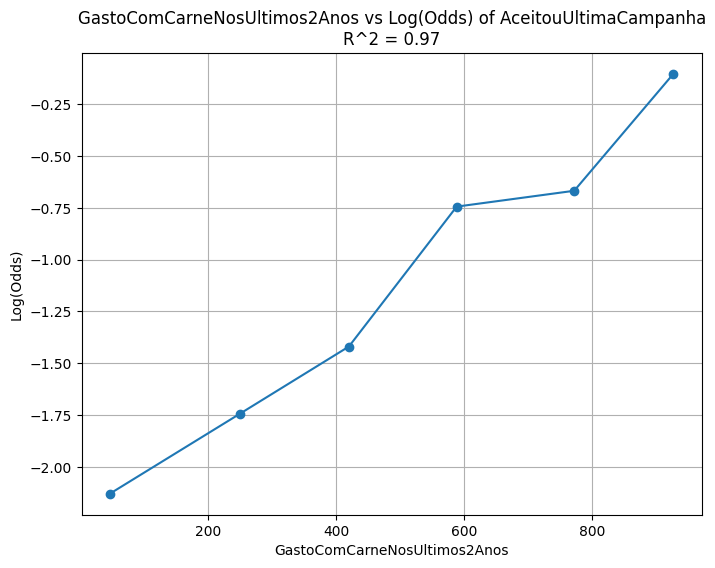

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


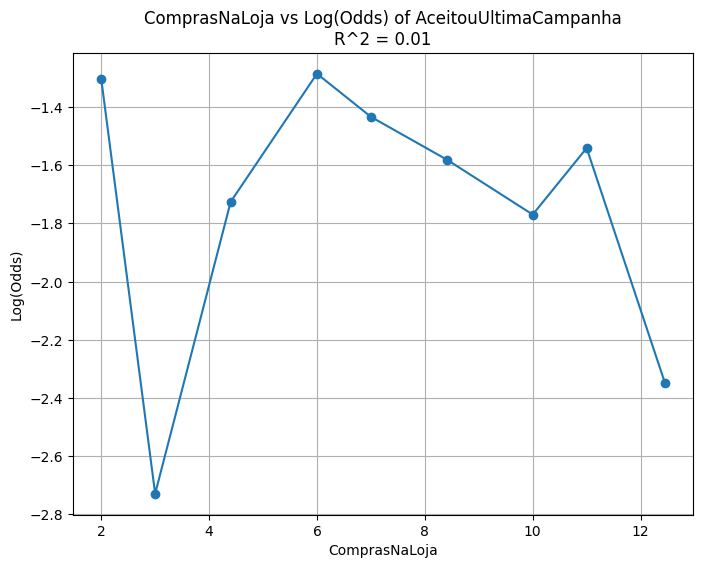

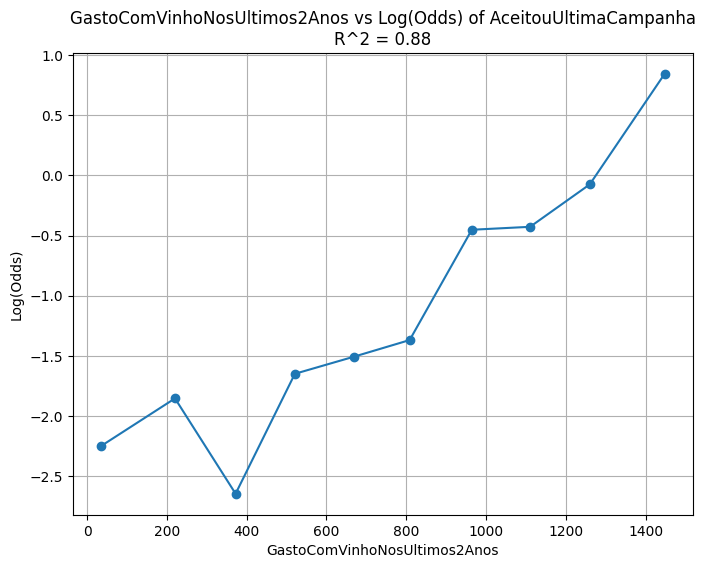

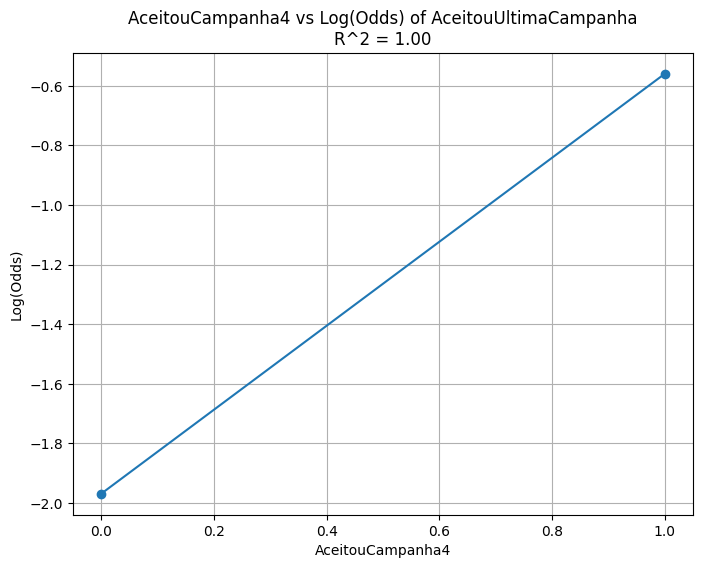

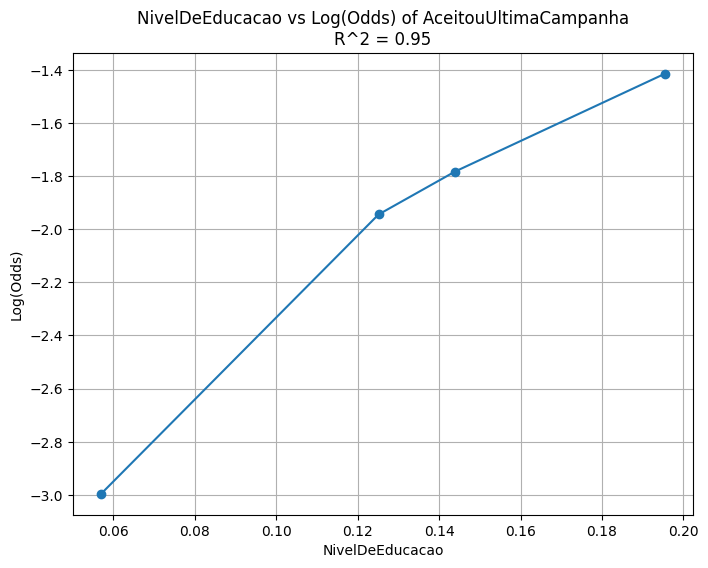

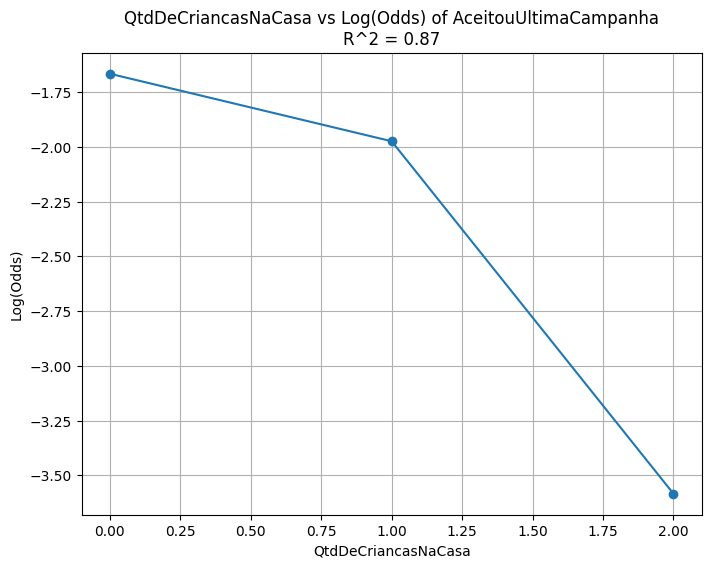

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


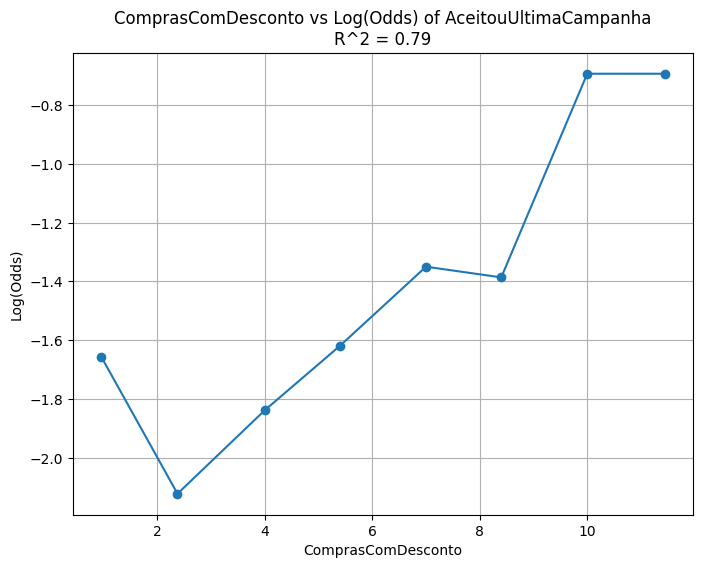

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


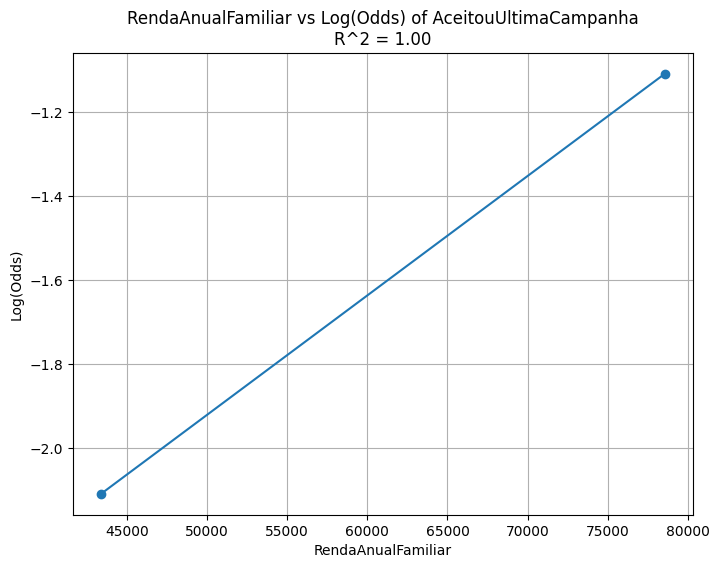

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


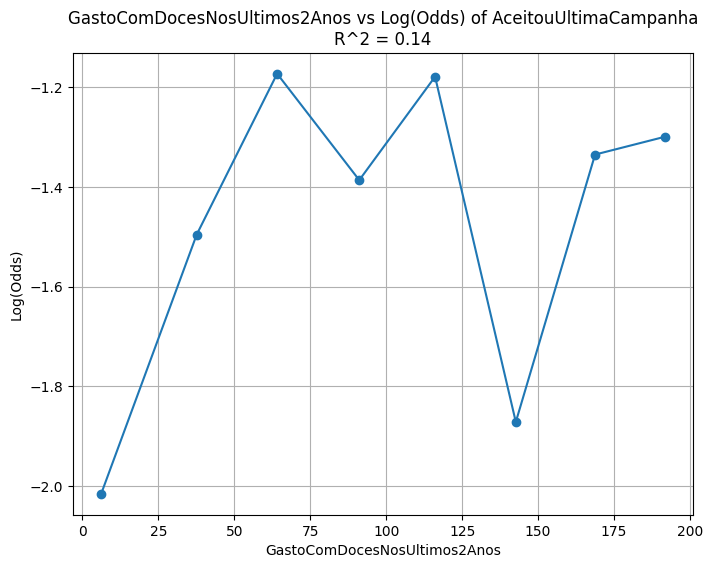

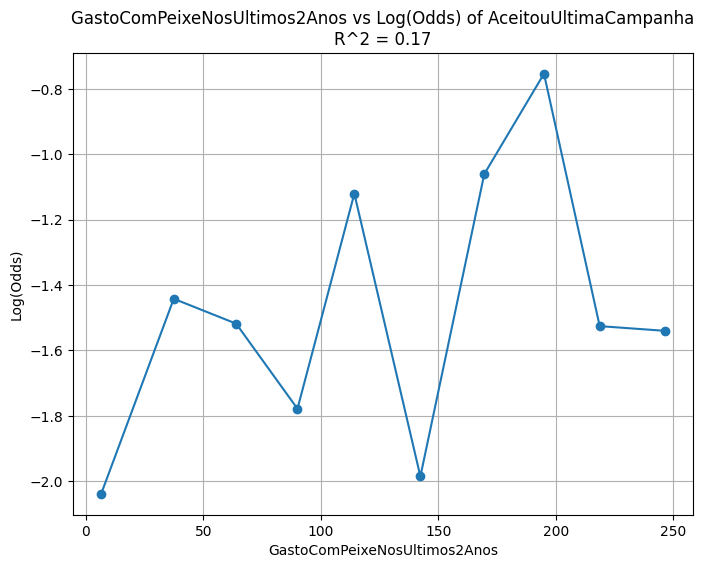

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


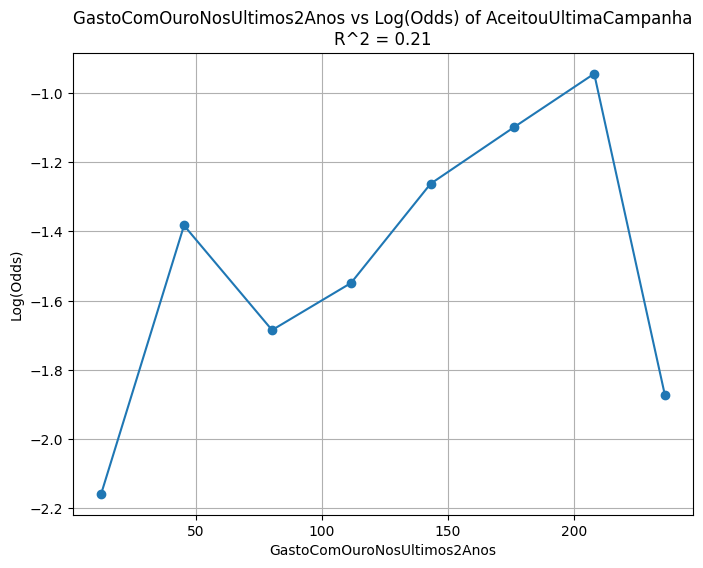

In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

def plot_variable_vs_logodds(df, variables, target):
    for variable in variables:
        # Verificando o número de valores únicos
        unique_vals = df[variable].nunique()
        if unique_vals == 1:
            print(f"{variable} tem apenas um valor único. Ignorando...")
            continue

        n_bins = min(10, unique_vals)

        # Criando bins para a variável
        df['bin'] = pd.cut(df[variable], bins=n_bins, labels=False, duplicates='drop')

        # Calculando a proporção de eventos positivos para cada bin
        mean_target = df.groupby('bin')[target].mean()

        # Calculando o log(odds) e tratando valores infinitos
        log_odds = np.log(mean_target / (1 - mean_target)).replace([np.inf, -np.inf], np.nan).dropna()

        # Calculando R^2
        X = df.groupby('bin')[variable].mean()[log_odds.index].values.reshape(-1, 1)
        y = log_odds.values
        model = LinearRegression().fit(X, y)
        r2 = model.score(X, y)

        # Plotando
        plt.figure(figsize=(8, 6))
        plt.plot(X, y, marker='o')
        plt.xlabel(variable)
        plt.ylabel('Log(Odds)')
        plt.title(f'{variable} vs Log(Odds) of {target}\nR^2 = {r2:.2f}')
        plt.grid(True)
        plt.show()

        # Removendo a coluna bin
        df.drop('bin', axis=1, inplace=True)

plot_variable_vs_logodds(new_abt_treino, list(new_abt_treino.drop(columns='AceitouUltimaCampanha').columns),'AceitouUltimaCampanha')

In [11]:
def calculate_r2_for_logodds(df, variables, target, threshold):
    results = []

    for variable in variables:
        # Verificando o número de valores únicos
        unique_vals = df[variable].nunique()
        if unique_vals == 1:
            print(f"{variable} tem apenas um valor único. Ignorando...")
            continue

        n_bins = min(10, unique_vals)

        # Criando bins para a variável
        df['bin'] = pd.cut(df[variable], bins=n_bins, labels=False, duplicates='drop')

        # Calculando a proporção de eventos positivos para cada bin
        mean_target = df.groupby('bin')[target].mean()

        # Calculando o log(odds) e tratando valores infinitos
        log_odds = np.log(mean_target / (1 - mean_target)).replace([np.inf, -np.inf], np.nan).dropna()

        # Calculando R^2
        X = df.groupby('bin')[variable].mean()[log_odds.index].values.reshape(-1, 1)
        y = log_odds.values
        model = LinearRegression().fit(X, y)
        r2 = model.score(X, y)

        # Decidindo sobre a engenharia de recursos com base no valor de R^2 e no threshold fornecido
        feat_eng = "Usar como contínua" if r2 > threshold else "Categorizar"

        results.append({
            'Variable': variable,
            'R^2': r2,
            'Feat Eng': feat_eng
        })

        # Removendo a coluna bin
        df.drop('bin', axis=1, inplace=True)

    return pd.DataFrame(results)

r2_df = calculate_r2_for_logodds(new_abt_treino, list(new_abt_treino.drop(columns='AceitouUltimaCampanha').columns), 'AceitouUltimaCampanha',threshold=0.85)
r2_df.loc[r2_df['Variable'].isin(vars_categoricas), 'Feat Eng'] = 'Categorizar'
r2_df

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = geta

,Variable,R^2,Feat Eng
0,AceitouCampanha5,1.000000,Usar como contínua
1,AceitouCampanha3,1.000000,Usar como contínua
2,AceitouCampanha1,1.000000,Usar como contínua
3,AceitouCampanha2,1.000000,Usar como contínua
4,DiasDesdeUltimaCompra,0.910978,Usar como contínua
5,EstadoCivil,0.510202,Categorizar
6,VisitasAoSiteNoUltimoMes,0.273495,Categorizar
7,ComprasPorCatalogo,0.995872,Usar como contínua
8,QtdDeAdolescentesNaCasa,0.830200,Categorizar
9,GastoComCarneNosUltimos2Anos,0.973594,Usar como contínua


In [12]:
variaveis_continuas = r2_df[r2_df['Feat Eng'] == 'Usar como contínua']['Variable'].tolist()
categorize_vars = r2_df[r2_df['Feat Eng'] == 'Categorizar']['Variable'].tolist()

### Avaliar se aplicar uma transformação matemática gera linearidade das demais variáveis com a log da odds

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

def calculate_r2_for_logodds_and_transformations(df, variables, target, threshold):
    results = []

    transformations = {
        'AbsLog': lambda x: np.log(np.abs(x) + 1),  # Adicionamos 1 para evitar log(0)
        'Quadratic': lambda x: x**2
    }

    for variable in variables:
        best_transform_r2 = -np.inf
        best_transform_name = 'None'
        best_transform_function = None

        for transform_name, transform_function in transformations.items():
            transformed_var = transform_function(df[variable])

            # Verificando o número de valores únicos
            unique_vals = transformed_var.nunique()
            if unique_vals == 1:
                continue

            n_bins = min(10, unique_vals)

            # Criando bins para a variável transformada
            df['bin'] = pd.cut(transformed_var, bins=n_bins, labels=False, duplicates='drop')

            # Calculando a proporção de eventos positivos para cada bin
            mean_target = df.groupby('bin')[target].mean()

            # Calculando o log(odds) e tratando valores infinitos
            log_odds = np.log(mean_target / (1 - mean_target)).replace([np.inf, -np.inf], np.nan).dropna()

            # Calculando R^2
            X = df.groupby('bin')[transformed_var.name].mean()[log_odds.index].values.reshape(-1, 1)
            y = log_odds.values
            model = LinearRegression().fit(X, y)
            r2 = model.score(X, y)

            # Se essa transformação for a melhor até agora, atualize as melhores variáveis
            if r2 > best_transform_r2:
                best_transform_r2 = r2
                best_transform_name = transform_name
                best_transform_function = transform_function

            # Removendo a coluna bin
            df.drop('bin', axis=1, inplace=True)

        feat_eng = "Usar como contínua" if best_transform_r2 > threshold else "Categorizar"

        results.append({
            'Variable': variable,
            'Best Transformation': best_transform_name,
            'R^2 of Transformation': best_transform_r2,
            'Feat Eng': feat_eng,
            'Transformation Equation': f'{best_transform_name}({variable})'
        })

    return pd.DataFrame(results)

results_df = calculate_r2_for_logodds_and_transformations(new_abt_treino, categorize_vars, 'AceitouUltimaCampanha',threshold=0.85)
results_df.loc[results_df['Variable'].isin(vars_categoricas), 'Feat Eng'] = 'Categorizar'
results_df

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = geta

,Variable,Best Transformation,R^2 of Transformation,Feat Eng,Transformation Equation
0,EstadoCivil,AbsLog,0.533994,Categorizar,AbsLog(EstadoCivil)
1,VisitasAoSiteNoUltimoMes,Quadratic,0.553676,Categorizar,Quadratic(VisitasAoSiteNoUltimoMes)
2,QtdDeAdolescentesNaCasa,Quadratic,1.000000,Usar como contínua,Quadratic(QtdDeAdolescentesNaCasa)
3,ComprasNaLoja,Quadratic,0.153370,Categorizar,Quadratic(ComprasNaLoja)
4,NivelDeEducacao,AbsLog,0.954992,Categorizar,AbsLog(NivelDeEducacao)
5,ComprasComDesconto,Quadratic,0.751309,Categorizar,Quadratic(ComprasComDesconto)
6,GastoComDocesNosUltimos2Anos,AbsLog,0.235465,Categorizar,AbsLog(GastoComDocesNosUltimos2Anos)
7,GastoComPeixeNosUltimos2Anos,AbsLog,0.595579,Categorizar,AbsLog(GastoComPeixeNosUltimos2Anos)
8,GastoComOuroNosUltimos2Anos,AbsLog,0.365764,Categorizar,AbsLog(GastoComOuroNosUltimos2Anos)


In [14]:
def apply_best_transformations(results_df, original_df, drop_original=False):
    transformed_df = original_df.copy()

    transformations = {
        'LogAbs': lambda x: np.log(np.abs(x) + 1),
        'Quadratic': lambda x: x**2
    }

    variables_transformed = []

    for index, row in results_df.iterrows():
        variable = row['Variable']
        best_transform_name = row['Best Transformation']
        feat_eng = row['Feat Eng']

        if feat_eng == 'Usar como contínua' and best_transform_name in transformations:
            transform_function = transformations[best_transform_name]
            transformed_var = transform_function(original_df[variable])
            transformed_df[f'TFE_{variable}'] = transformed_var
            variables_transformed.append(variable)

    # Descarta as variáveis originais se drop_original for True
    if drop_original:
        transformed_df.drop(variables_transformed, axis=1, inplace=True)

    return transformed_df

new_abt_treino_transform = apply_best_transformations(results_df, new_abt_treino,drop_original=True)
new_abt_teste_transform = apply_best_transformations(results_df, new_abt_teste,drop_original=True)

In [15]:
var = list(results_df[results_df['Feat Eng'] == 'Usar como contínua'].Variable)
var = ["TFE_" + variavel for variavel in var]
variaveis_continuas += var

## Categorização

### Categorizar as variáveis que estão não apresentaram comportamento linear com a log da odds


In [16]:
# Cálculo do R² considerando o dataset atualizado
r2_df = calculate_r2_for_logodds(new_abt_treino_transform, new_abt_treino_transform.drop(columns=['AceitouUltimaCampanha']), 'AceitouUltimaCampanha',threshold=0.85)
r2_df.loc[r2_df['Variable'].isin(vars_categoricas), 'Feat Eng'] = 'Categorizar'

# Separar variáveis que ainda não se tornaram linear com o log da odds mesmo após as transformações
variaveis_categorizar = r2_df[r2_df['Feat Eng'] == 'Categorizar'].Variable.to_list()

# Verificar cardinalidade dessas variáveis
df = pod_academy_generate_metadata(new_abt_treino_transform[variaveis_categorizar])


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = geta

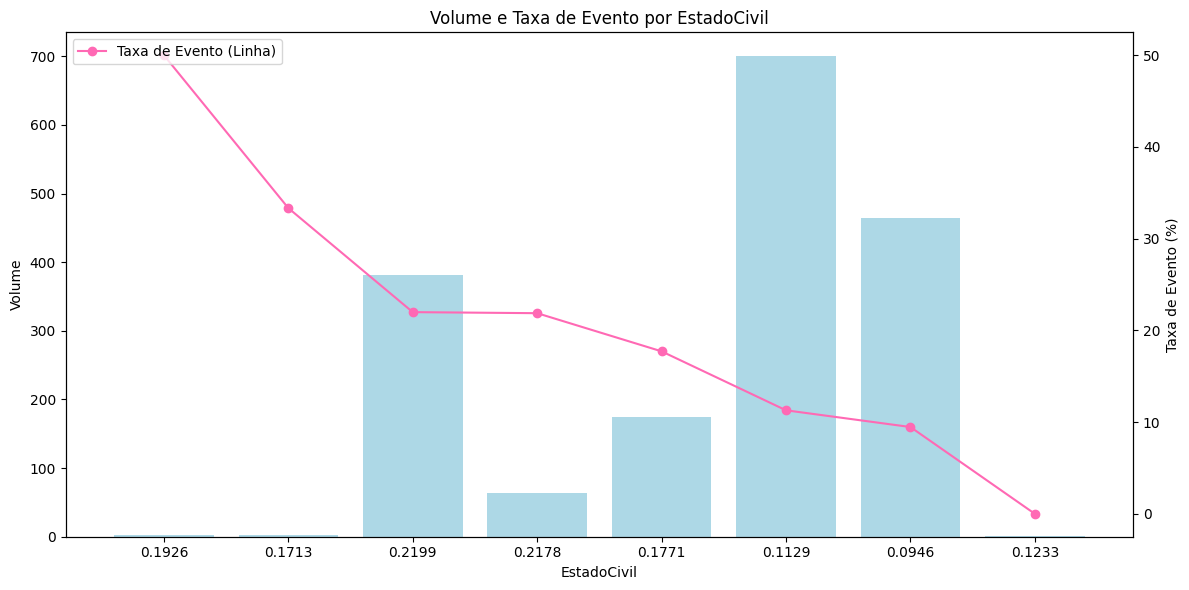

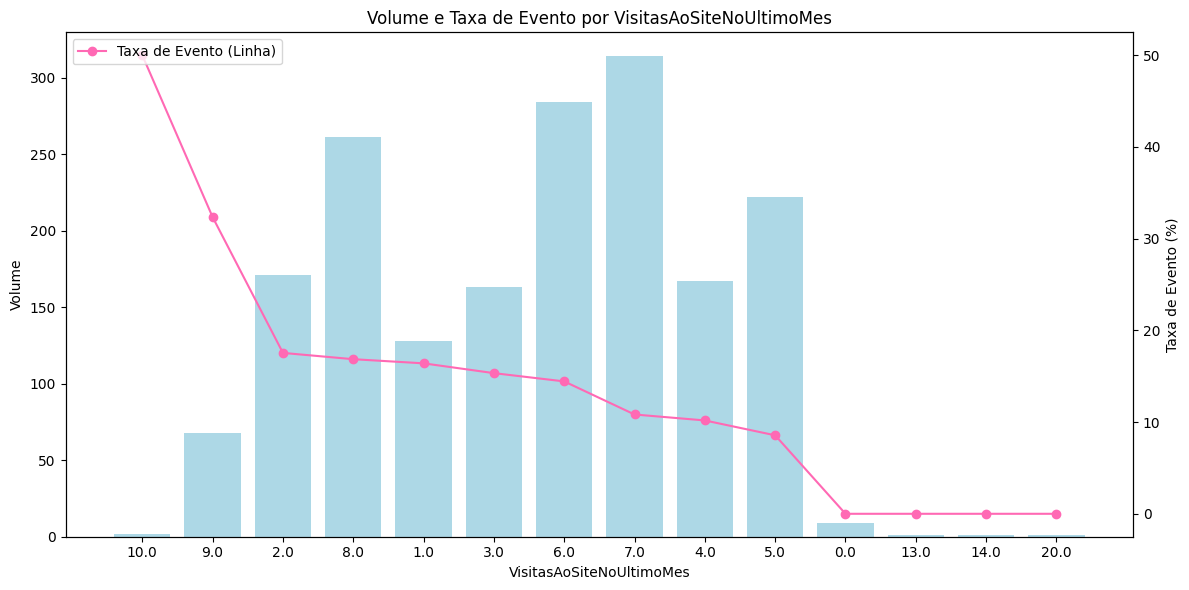

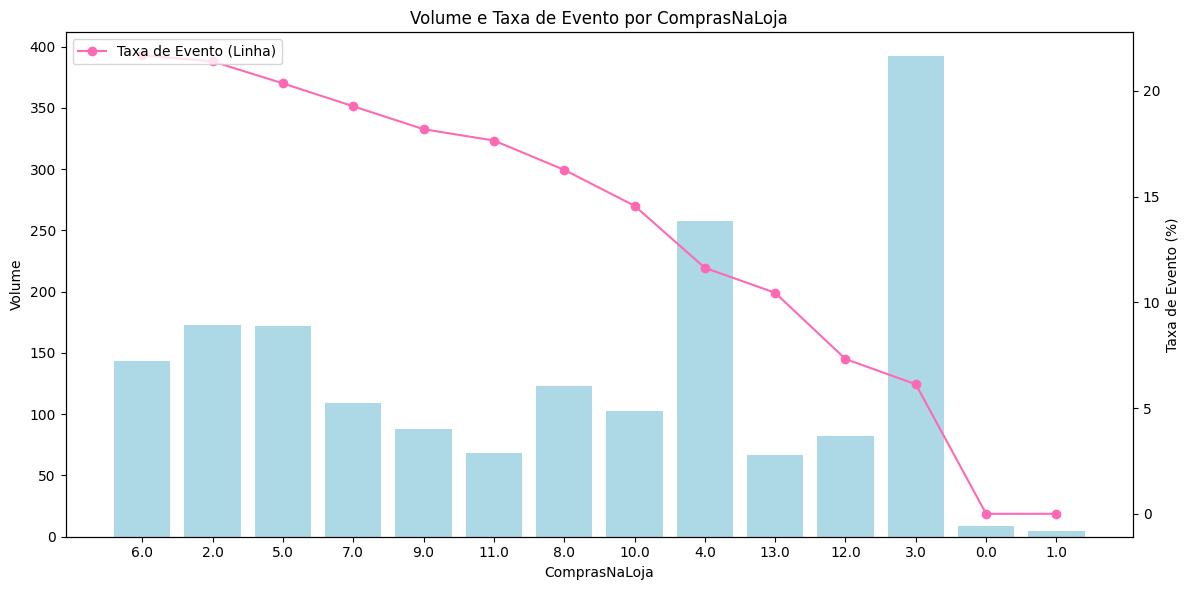

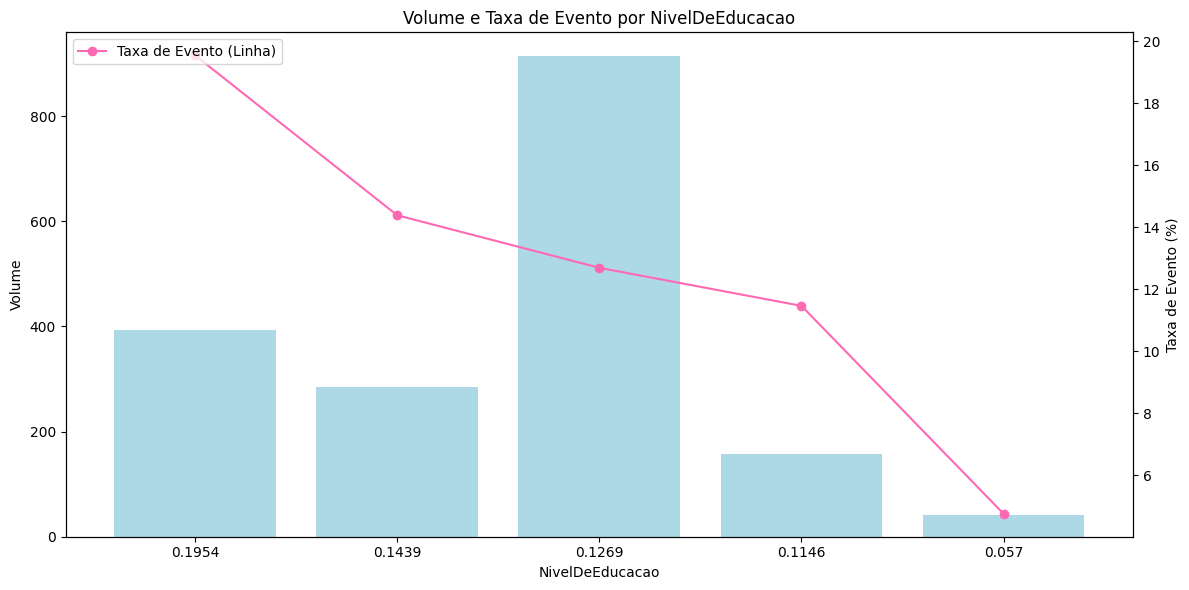

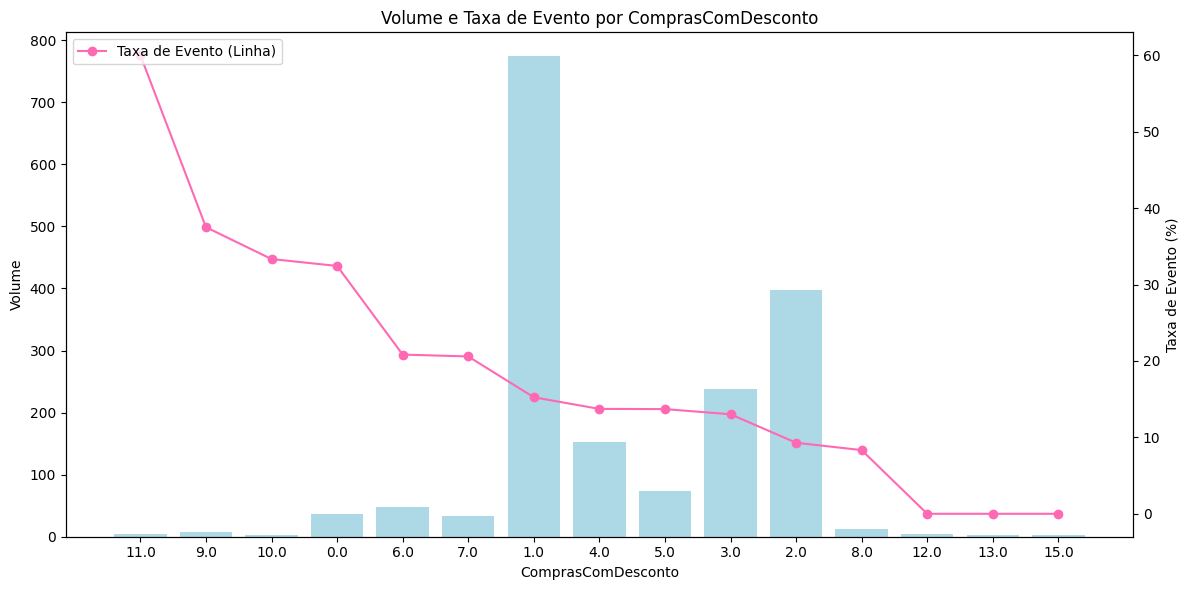

In [17]:
# Analizar essas variáveis (variaveis_categorizar) que contém baixa cardinalidade (menor ou igual a 20) e verificar se há ordenação entre as categorias
ordinais = df[df.cardinalidade <= 20].nome_variavel.to_list()

def analyze_variable(dataframe, variable, target):

    # Se a variável for numérica, arredonda para 4 casas decimais
    if pd.api.types.is_numeric_dtype(dataframe[variable]):
        dataframe[variable] = dataframe[variable].round(4)
        dataframe[variable] = dataframe[variable].astype(str)

    # Calcula a taxa de evento e o volume para cada categoria da variável
    result = dataframe.groupby(variable).agg({target: 'mean', variable: 'count'}).rename(columns={variable: 'Volume'}).reset_index()
    result.columns = [variable, 'Taxa_de_Evento', 'Volume']

    # Ordena o resultado pela Taxa de Evento em ordem decrescente
    result = result.sort_values(by='Taxa_de_Evento', ascending=False)

    # Plota o gráfico
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Eixo Y esquerdo: Volume
    bars = ax1.bar(result[variable], result['Volume'], color='lightblue', label='Volume (Barras)')
    ax1.set_xlabel(variable)
    ax1.set_ylabel('Volume', color='black')
    ax1.tick_params(axis='y', labelcolor='black')

    # Eixo Y direito: Taxa de Evento
    ax2 = ax1.twinx()
    lines = ax2.plot(result[variable], result['Taxa_de_Evento'] * 100, marker='o', linestyle='-', color='hotpink', label='Taxa de Evento (Linha)')
    ax2.set_ylabel('Taxa de Evento (%)', color='black')
    ax2.tick_params(axis='y', labelcolor='black')

    # Combina as legendas de ambos os eixos, filtrando rótulos que começam com '_'
    plots = [item for item in bars + tuple(lines) if not item.get_label().startswith('_')]
    labels = [plot.get_label() for plot in plots]
    plt.legend(plots, labels, loc='upper left')

    plt.title(f'Volume e Taxa de Evento por {variable}')
    plt.xticks(rotation=45)  # Adicionado para melhor visualização dos labels no eixo X
    plt.tight_layout()
    plt.show()

    return result

for var in ordinais:
    result = analyze_variable(new_abt_treino_transform, var, "AceitouUltimaCampanha")

In [18]:
def categorize_with_decision_tree(dataframe, n_categories, target, numeric_var):
    import numpy as np
    import pandas as pd
    from sklearn.tree import DecisionTreeClassifier

    # Preparar os dados
    X = dataframe[[numeric_var]]
    y = dataframe[target]

    # Verificar se n_categories é 1 para tratar o caso especial
    if n_categories == 1:
        return pd.DataFrame({
            'Leaf': [1],
            'Taxa_de_Evento': [y.mean()],
            'Volume': [len(y)],
            'Lower_Bound': [-np.inf],
            'Upper_Bound': [np.inf]
        })

    # Treinar uma árvore de decisão com profundidade máxima igual ao número de categorias desejadas
    tree = DecisionTreeClassifier(max_leaf_nodes=n_categories)
    tree.fit(X, y)

    # Predizer a categoria (folha) para cada entrada no DataFrame
    leaf_ids = tree.apply(X)

    # Criar um DataFrame temporário com as categorias (folhas), a variável numérica e o target
    temp_df = pd.DataFrame({numeric_var: dataframe[numeric_var], 'Leaf': leaf_ids, target: y})

    result = temp_df.groupby('Leaf').agg({target: 'mean', numeric_var: ['count', 'min', 'max']}).reset_index()
    result.columns = ['Leaf', 'Taxa_de_Evento', 'Volume', 'Lower_Bound', 'Upper_Bound']

    # Ajuste para garantir que os limites superior e inferior de bins adjacentes não se sobreponham
    result = result.sort_values(by='Lower_Bound')
    for i in range(1, len(result)):
        result.iloc[i, 3] = max(result.iloc[i, 3], result.iloc[i-1, 4])

    # Definir o limite inferior do primeiro bin como -inf e o limite superior do último bin como inf
    result.iloc[0, 3] = -np.inf
    result.iloc[-1, 4] = np.inf

    return result

def apply_tree_bins(data, transformation_df, numeric_var):
    import numpy as np
    import pandas as pd

    df_copy = data.copy()

    # Verificar se há apenas uma categoria
    if len(transformation_df) == 1:
        # Atribuir a mesma categoria para todas as observações
        df_copy[f"TFT_{numeric_var}"] = 1
    else:
        transformation_df.Upper_Bound = transformation_df.Upper_Bound.astype('float')
        transformation_df.Lower_Bound = transformation_df.Lower_Bound.astype('float')

        # Obter os limites superiores e ordene-os
        upper_bounds = transformation_df['Upper_Bound'].sort_values().values

        # Use numpy.digitize para determinar a qual bin cada valor pertence
        df_copy[f"TFT_{numeric_var}"] = np.digitize(df_copy[numeric_var].astype(float), upper_bounds)

    df_copy.drop(axis=1, columns=[numeric_var], inplace=True)

    return df_copy

In [19]:
variaveis_categorizar

['EstadoCivil',
 'VisitasAoSiteNoUltimoMes',
 'ComprasNaLoja',
 'NivelDeEducacao',
 'ComprasComDesconto',
 'GastoComDocesNosUltimos2Anos',
 'GastoComPeixeNosUltimos2Anos',
 'GastoComOuroNosUltimos2Anos']

In [20]:
from sklearn.metrics import roc_auc_score

def encontrar_melhor_n_categorias(df, target, var_num, n_categorias_range):
    '''
    Desenvolvido por: Estênio Mariano - Github: https://github.com/emso-exe/
    Encontra o melhor número de categorias (bins) para uma variável utilizando
    uma árvore de decisão, baseado na maximização da métrica AUC-ROC.

    :param df: DataFrame
        DataFrame contendo as variáveis independentes e a variável dependente.
    :param target: str
        Nome da coluna do DataFrame que contém a variável dependente (alvo).
    :param var_num: str
        Nome da coluna da variável numérica que será categorizada.
    :param n_categorias_range: range
        Intervalo de números de categorias (bins) a serem testados.

    :return:
        - melhor_n_categorias (int): O número de categorias que maximiza a AUC-ROC.
        - melhores_resultados (list): Lista com os resultados da AUC-ROC para cada número de categorias testado.
    '''

    melhores_resultados = []

    for n in n_categorias_range:
        # Categorizar a variável com o número atual de categorias
        resultado = categorize_with_decision_tree(df, n, target, var_num)

        # Aplicar a categorização ao DataFrame
        df_transf = apply_tree_bins(df, resultado, var_num)

        # Avaliar a métrica - neste caso, usando AUC-ROC
        auc = roc_auc_score(df[target], df_transf[f'TFT_{var_num}'])

        # Guardar o resultado para este número de categorias
        melhores_resultados.append((n, auc))

    # Escolher o n_categorias que maximiza a AUC-ROC
    melhor_n_categorias = max(melhores_resultados, key=lambda x: x[1])[0]

    return melhor_n_categorias, melhores_resultados


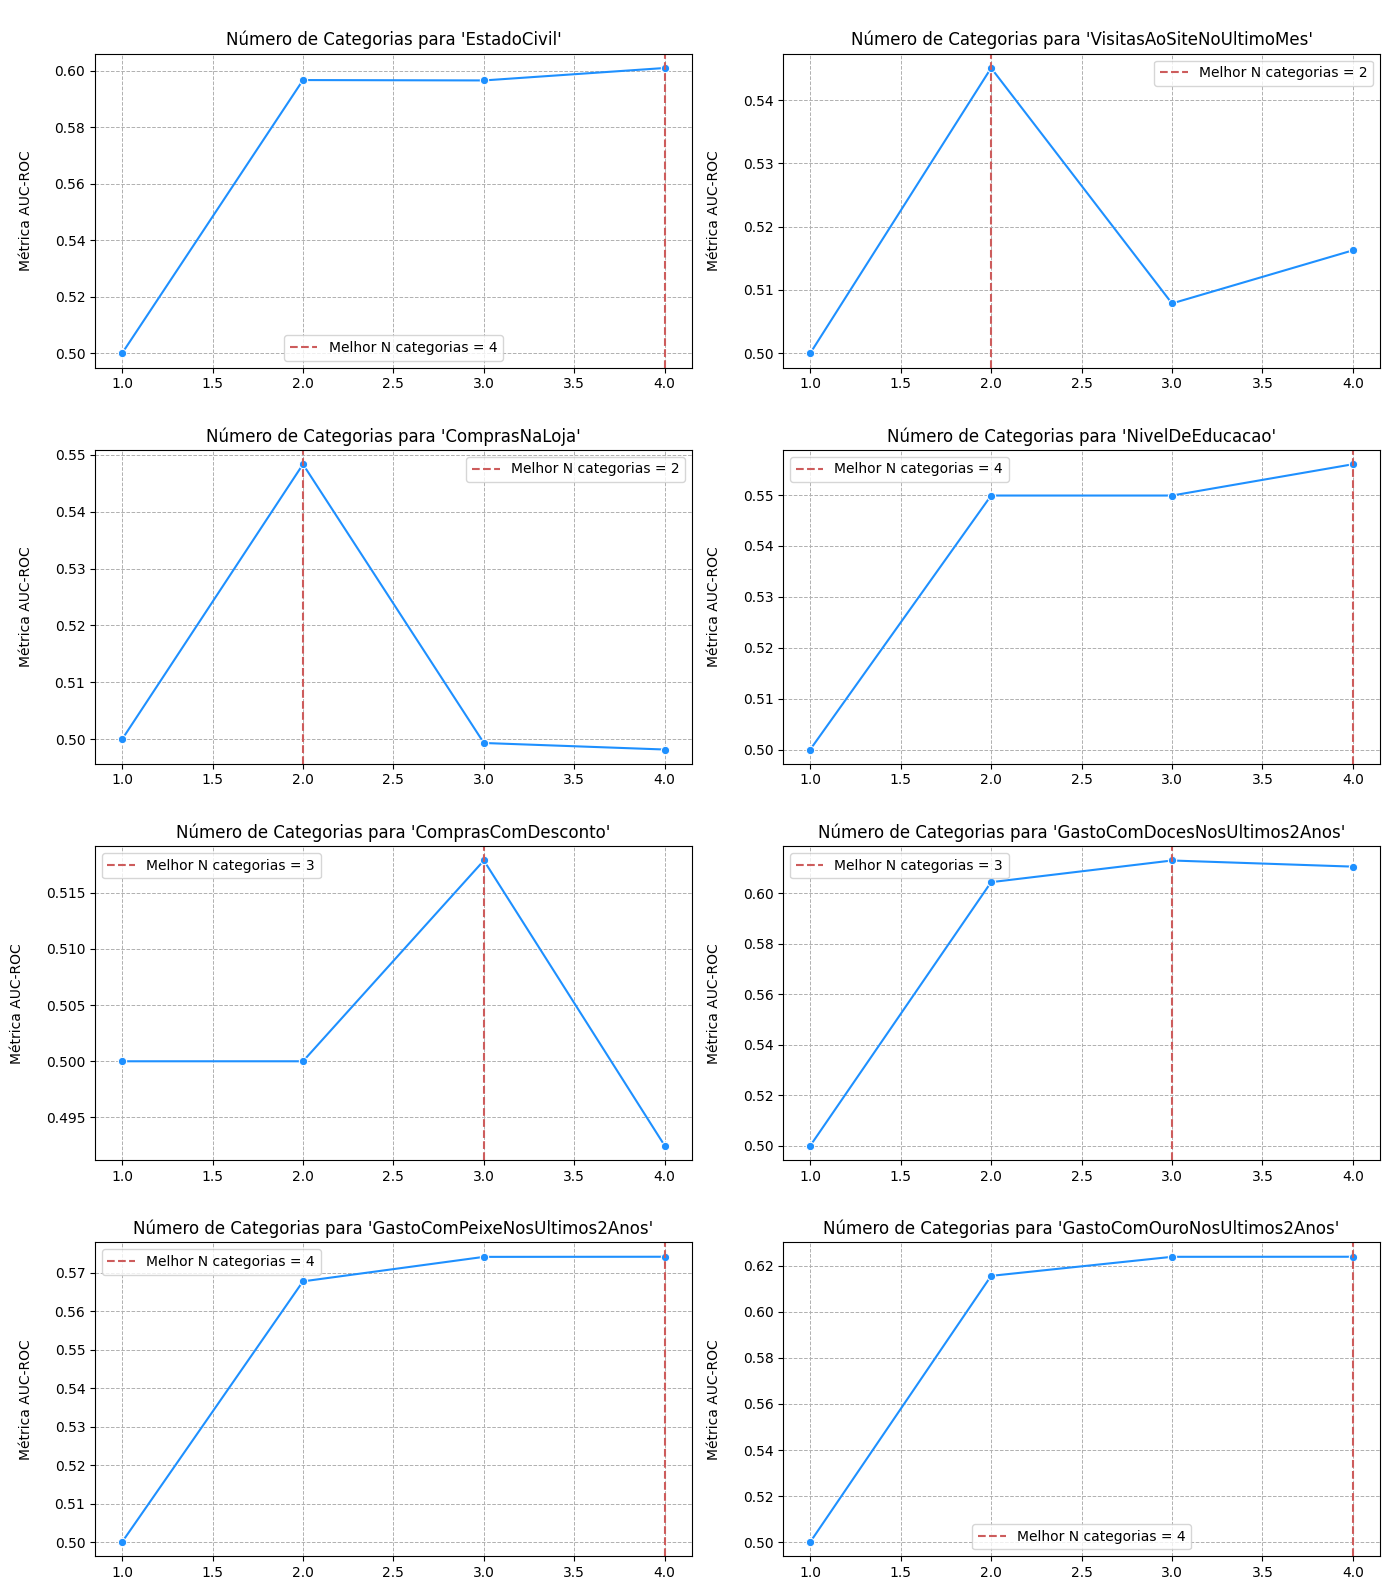

In [21]:
# Definir o número de colunas
num_cols = 2
num_rows = len(variaveis_categorizar) // num_cols + (len(variaveis_categorizar) % num_cols > 0)

# Criar um grid de subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(14, num_rows * 4))

# Achatar a matriz de eixos para iterar facilmente
axes = axes.flatten()

for idx, var in enumerate(variaveis_categorizar):
    # Executa a função e armazena o resultado em uma tupla
    melhor_n_categorias, resultados = encontrar_melhor_n_categorias(new_abt_treino_transform, 'AceitouUltimaCampanha', var, range(1, 5))

    # Extrair valores de n_categorias e AUC-ROC a partir da lista de resultados
    n_categorias_vals = [res[0] for res in resultados]
    auc_vals = [res[1] for res in resultados]

    # Criar o gráfico de lineplot no eixo correspondente
    sns.lineplot(ax=axes[idx], x=n_categorias_vals, y=auc_vals, marker='o', color='dodgerblue')

    # Encontrar o primeiro ponto mais alto e marcá-lo com uma linha tracejada
    max_auc_idx = auc_vals.index(max(auc_vals))
    axes[idx].axvline(x=n_categorias_vals[max_auc_idx], color='indianred', linestyle='--',
                      label=f'Melhor N categorias = {n_categorias_vals[max_auc_idx]}')

    # Adicionar rótulos e título
    axes[idx].set_title(f'\nNúmero de Categorias para \'{var}\'')
    axes[idx].set_xlabel('')
    axes[idx].set_ylabel('Métrica AUC-ROC\n')
    axes[idx].grid(True, which='both', linestyle='--', linewidth=0.7)
    axes[idx].legend()

# Remover subplots vazios, caso haja
for i in range(idx + 1, len(axes)):
    fig.delaxes(axes[i])

# Ajustar layout para não sobrepor elementos
plt.tight_layout()

# Exibir os gráficos
plt.show()

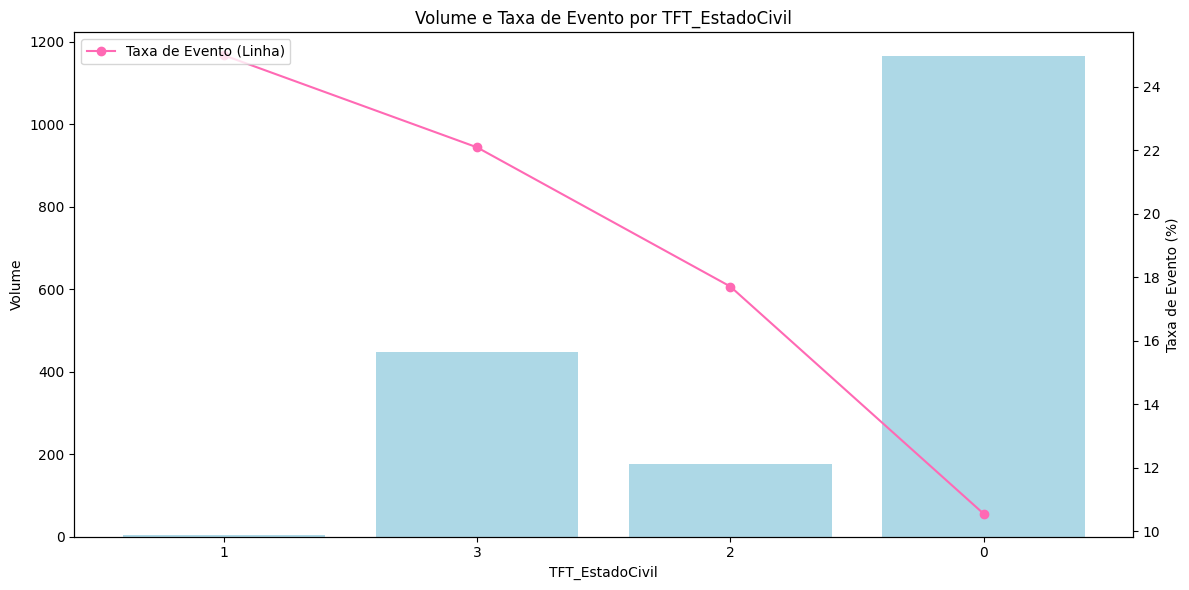

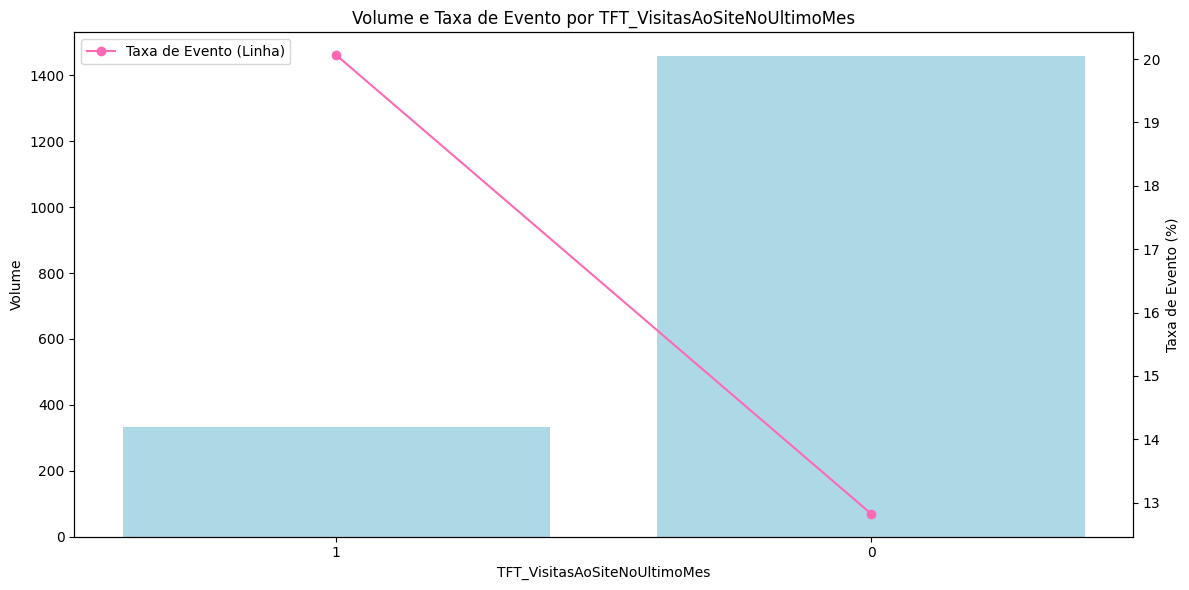

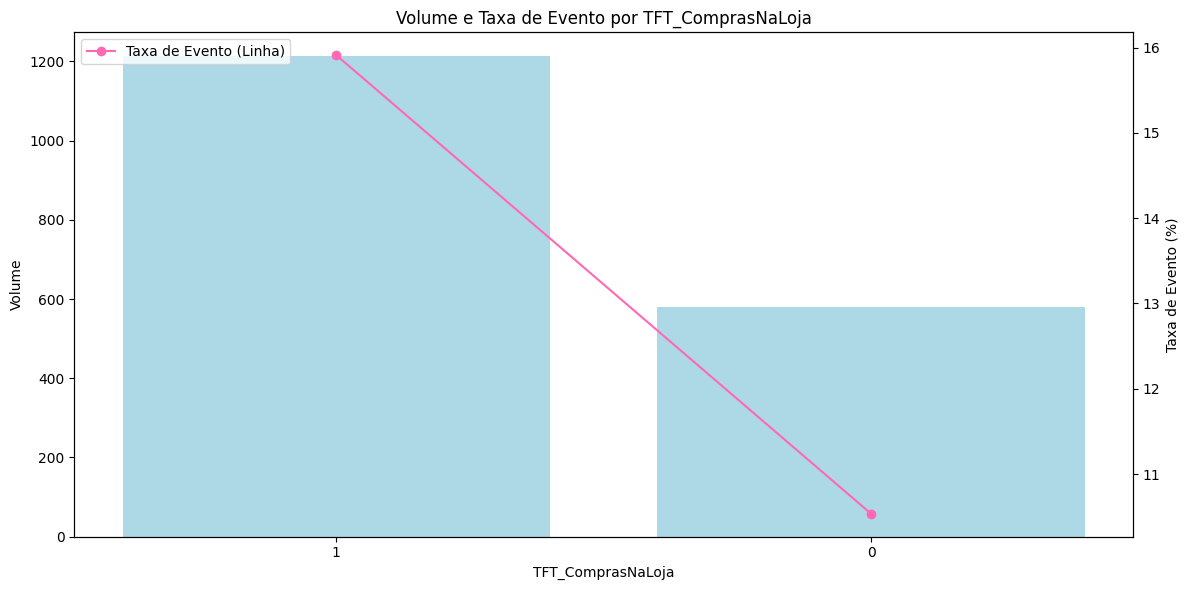

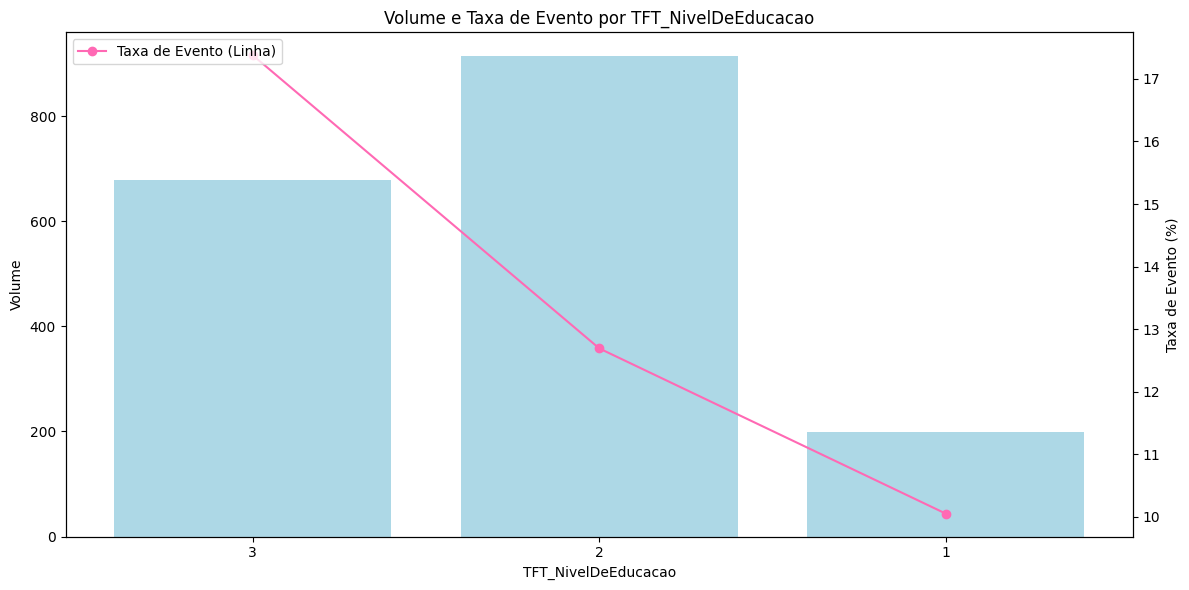

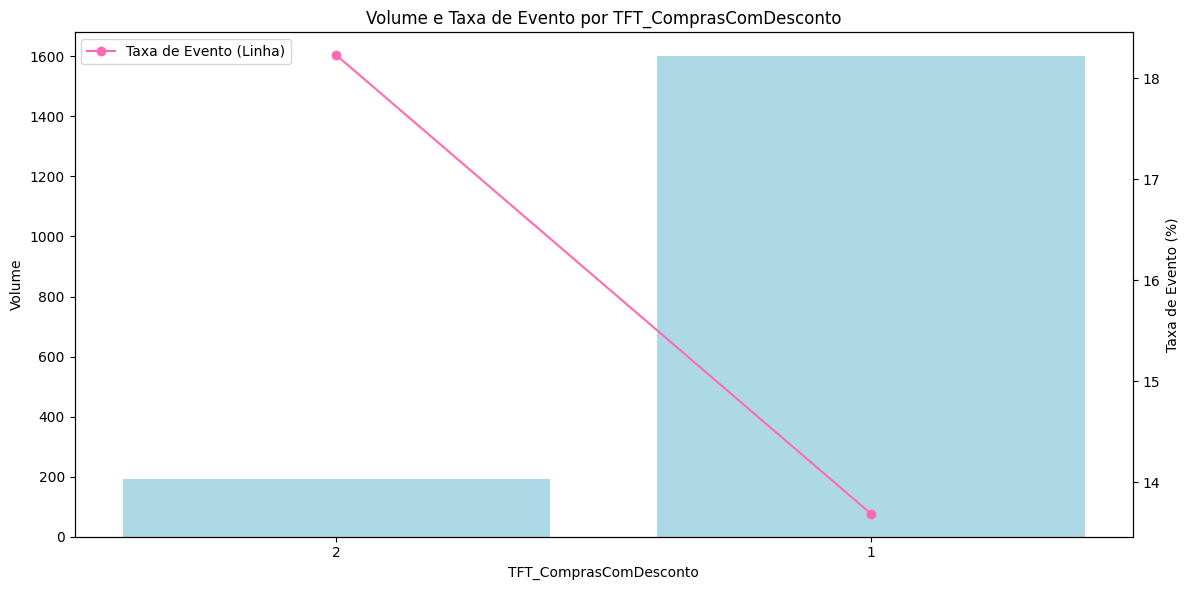

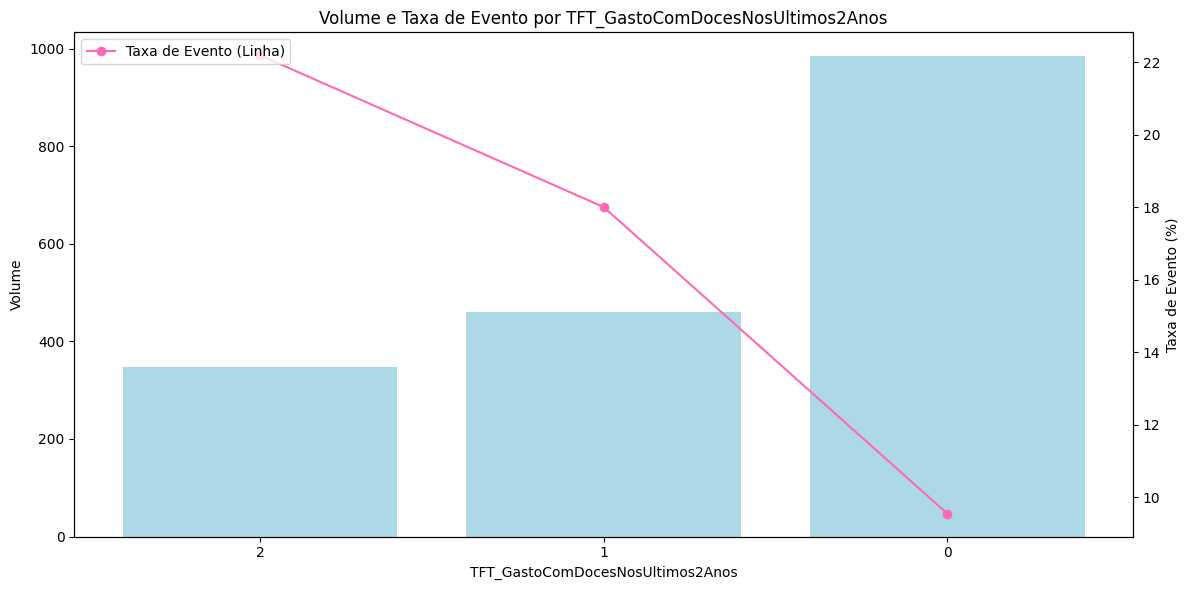

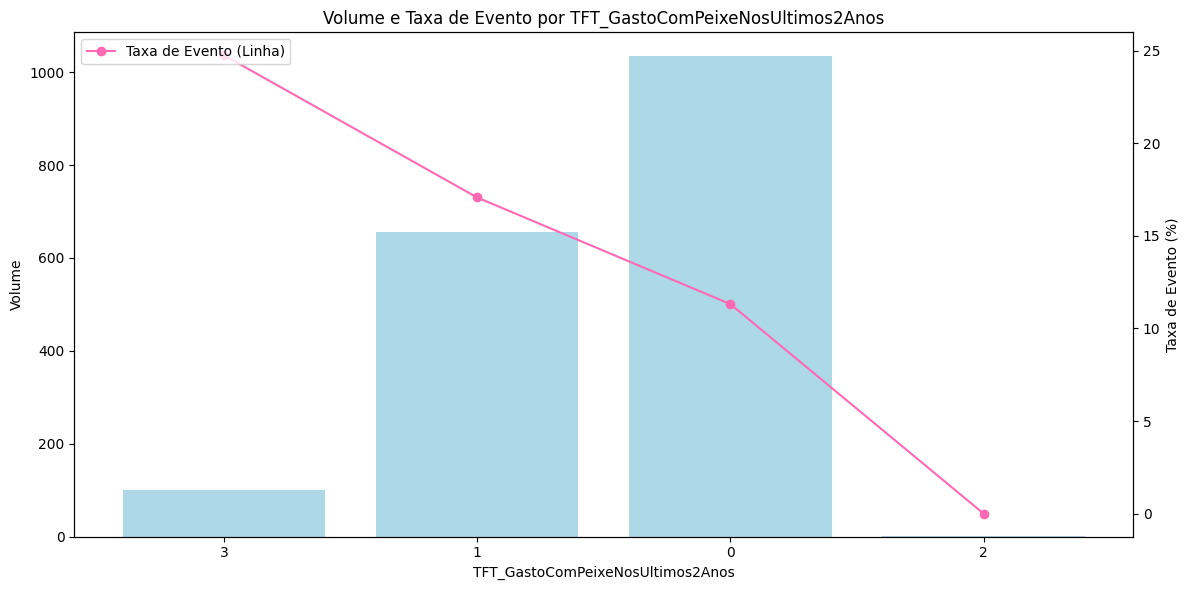

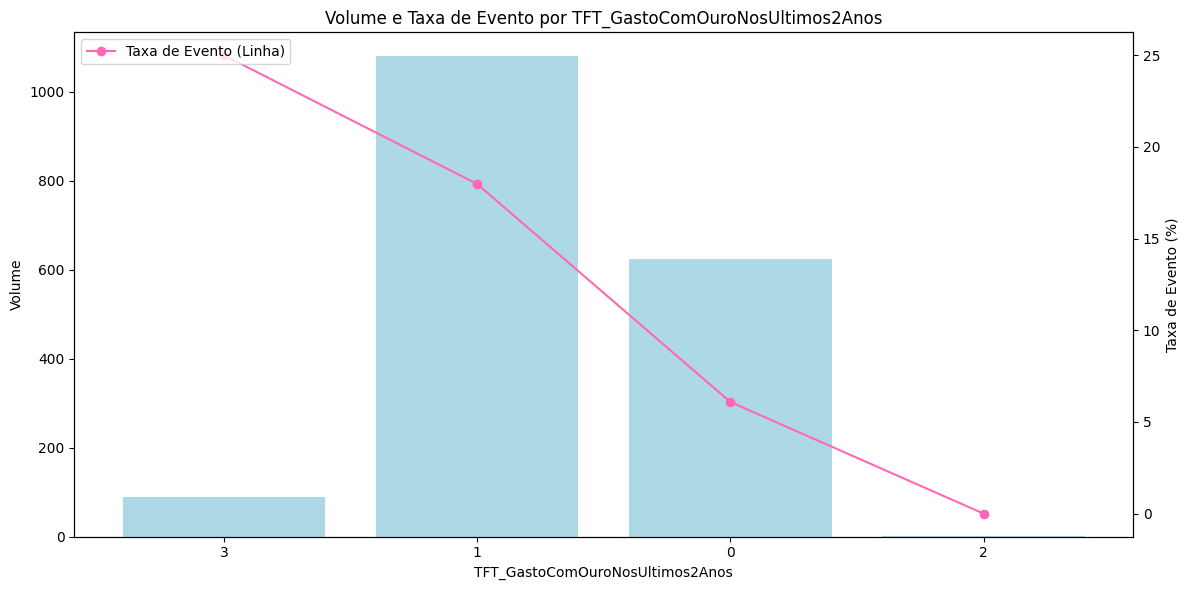

In [22]:
# Cópia dos dataframes
df_treino_01 = new_abt_treino_transform.copy()
df_teste_01 = new_abt_teste_transform.copy()

for var in variaveis_categorizar:
    # Encontra o melhor número de categorias para a variável por meio de métricas
    n, r = encontrar_melhor_n_categorias(new_abt_treino_transform, 'AceitouUltimaCampanha', var, range(1, 5))

    nome_tft = 'TFT_' + var

    # Aplica um modelo de árvore de decisão de acordo com o número de categorias (folhas)
    result = categorize_with_decision_tree(new_abt_treino_transform, n_categories=n, target='AceitouUltimaCampanha', numeric_var=var)

    # Aplicar a quantidade de categorias escolhida
    novas_colunas_treino = apply_tree_bins(new_abt_treino_transform, result, numeric_var=var)
    novas_colunas_teste = apply_tree_bins(new_abt_teste_transform, result, numeric_var=var)

    # Gera os gráficos para análise das novas variáveis criadas
    results = analyze_variable(novas_colunas_treino, nome_tft, 'AceitouUltimaCampanha')

    # Selecionar apenas as colunas que não existiam anteriormente
    novas_colunas_treino = novas_colunas_treino.loc[:, ~novas_colunas_treino.columns.isin(df_treino_01.columns)]
    novas_colunas_teste = novas_colunas_teste.loc[:, ~novas_colunas_teste.columns.isin(df_teste_01.columns)]

    # Adicionar ao df_treino_01 e df_teste_01
    df_treino_01 = df_treino_01.join(novas_colunas_treino)
    df_teste_01 = df_teste_01.join(novas_colunas_teste)


In [23]:
# Removendo as variáveis originais antes da categorização
for var in variaveis_categorizar:
    df_treino_01.drop(var, axis='columns', inplace=True)
    df_teste_01.drop(var, axis='columns', inplace=True)

In [24]:
# Ajuste no tipo de variável
lista_onehot = ["TFT_" + variavel for variavel in variaveis_categorizar]
for var in lista_onehot:
  df_treino_01[var] = df_treino_01[var].astype(float)
  df_teste_01[var] = df_teste_01[var].astype(float)

import pickle
from sklearn.preprocessing import OneHotEncoder

X = df_treino_01.drop(axis=1,columns=['AceitouUltimaCampanha'])

print('Lista de vars para OneHot Encoding: ',lista_onehot)

# Instanciando o encoder
encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore',dtype=np.int32)
# Aplicando o one-hot encoding
encoded_data = encoder.fit_transform(df_treino_01[lista_onehot])
encoded_cols = encoder.get_feature_names_out(lista_onehot)
encoded_df = pd.DataFrame(encoded_data, columns=encoded_cols, index=df_treino_01.index)

df_train_03 = pd.concat([df_treino_01.drop(lista_onehot, axis=1), encoded_df], axis=1)

# Salva o encoder e a lista de colunas em um arquivo .pkl
data_to_serialize = {
    'encoder': encoder,
    'columns': lista_onehot
}

Lista de vars para OneHot Encoding:  ['TFT_EstadoCivil', 'TFT_VisitasAoSiteNoUltimoMes', 'TFT_ComprasNaLoja', 'TFT_NivelDeEducacao', 'TFT_ComprasComDesconto', 'TFT_GastoComDocesNosUltimos2Anos', 'TFT_GastoComPeixeNosUltimos2Anos', 'TFT_GastoComOuroNosUltimos2Anos']


In [25]:

encoded_data_test = encoder.transform(df_teste_01[lista_onehot])
encoded_cols_test = encoder.get_feature_names_out(lista_onehot)
encoded_df_test = pd.DataFrame(encoded_data_test, columns=encoded_cols_test, index=df_teste_01.index)

df_teste_01 = pd.concat([df_teste_01.drop(lista_onehot, axis=1), encoded_df_test], axis=1)

X = df_train_03.drop(axis=1,columns=['AceitouUltimaCampanha'])

lista_features_rl = list(X.columns)

In [26]:
import pandas as pd
import statsmodels.api as sm

def logistic_regression_with_scorecard(data, target_var, features):

    data = data[features+[target_var]].copy()

    # Adicionando uma constante ao dataset (intercepto)
    data = sm.add_constant(data)

    # Ajustando o modelo de regressão logística
    model = sm.Logit(data[target_var], data[features + ['const']]).fit()
    # model = sm.Logit(data[target_var], data[features]).fit()

    # Coletando p-valores e estatísticas de Wald
    summary = model.summary2().tables[1]
    summary['Wald'] = summary['z']**2
    scorecard = summary[['Coef.', 'P>|z|', 'Wald']]
    scorecard.columns = ['Beta Coefficient', 'P-Value', 'Wald Statistic']
    scorecard = scorecard.sort_values(by='Wald Statistic', ascending=False)

    return model, scorecard

model, scorecard = logistic_regression_with_scorecard(df_train_03, 'AceitouUltimaCampanha', lista_features_rl)
scorecard

         Current function value: 0.265795
         Iterations: 35


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


,Beta Coefficient,P-Value,Wald Statistic
DiasDesdeUltimaCompra,-0.027805,2.152598e-17,7.199943e+01
AceitouCampanha3,1.774849,1.182070e-12,5.051584e+01
TFT_EstadoCivil_3.0,1.208365,1.736218e-10,4.074303e+01
const,-3.120362,4.493097e-10,3.888592e+01
AceitouCampanha5,1.682345,4.175074e-08,3.006638e+01
AceitouCampanha1,1.382327,3.097757e-06,2.175504e+01
TFT_NivelDeEducacao_3.0,1.499033,8.883532e-06,1.973762e+01
TFT_GastoComOuroNosUltimos2Anos_1.0,1.087754,1.562154e-05,1.866013e+01
TFT_EstadoCivil_2.0,1.178500,1.635780e-05,1.857233e+01
TFT_VisitasAoSiteNoUltimoMes_1.0,0.937381,3.070188e-05,1.737386e+01


In [27]:
lista = pd.DataFrame(scorecard[scorecard['P-Value'] <= 0.05].reset_index()).rename(columns={'index':'variable'}).variable.to_list()
try:
    lista.remove('const')
except:
    pass

abt_new = df_train_03[lista]
abt_new = pd.concat((abt_new,y_train),axis=1)
abt_test_new = df_teste_01[lista]
abt_test_new = pd.concat((abt_test_new,y_test),axis=1)

model, scorecard = logistic_regression_with_scorecard(abt_new, 'AceitouUltimaCampanha', abt_new.drop(columns='AceitouUltimaCampanha').columns.to_list())
scorecard

Optimization terminated successfully.
         Current function value: 0.270783
         Iterations 8


,Beta Coefficient,P-Value,Wald Statistic
DiasDesdeUltimaCompra,-0.026833,8.673065e-17,69.250234
AceitouCampanha3,1.883759,1.540564e-14,59.045646
const,-2.278948,8.393405e-11,42.163927
TFT_EstadoCivil_3.0,1.188332,1.761254e-10,40.715051
AceitouCampanha5,1.701314,6.686439e-09,33.623949
TFT_NivelDeEducacao_3.0,0.933395,2.138250e-07,26.903918
AceitouCampanha1,1.377313,1.889612e-06,22.704131
TFT_VisitasAoSiteNoUltimoMes_1.0,0.943719,1.540872e-05,18.686280
TFT_EstadoCivil_2.0,1.121609,3.528801e-05,17.109358
GastoComCarneNosUltimos2Anos,0.001946,4.470094e-05,16.660553


In [28]:
abt_train_t01 = abt_new.drop(columns='AceitouUltimaCampanha').copy()
abt_teste_t01 = abt_test_new.drop(columns='AceitouUltimaCampanha').copy()

abt_train_t01['const'] = 1.0
abt_teste_t01['const'] = 1.0

abt_train_t01['Score_1'] = model.predict(abt_train_t01).round(4)
abt_teste_t01['Score_1'] = model.predict(abt_teste_t01).round(4)

abt_train_t01['Score_0'] = 1 - abt_train_t01['Score_1']
abt_teste_t01['Score_0'] = 1 - abt_teste_t01['Score_1']

abt_train_t01 = pd.concat((abt_train_t01,y_train),axis=1)
abt_teste_t01 = pd.concat((abt_teste_t01,y_test),axis=1)

In [29]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
import pandas as pd
import numpy as np

def calculate_metrics(train_df, test_df, score_column, target_column,bins=10):
    def compute_metrics(df, score_column, target_column):
        df_sorted = df.sort_values(by=score_column, ascending=False)

        # Calcular KS
        df_sorted['cum_good'] = (1 - df_sorted[target_column]).cumsum() / (1 - df_sorted[target_column]).sum()
        df_sorted['cum_bad'] = df_sorted[target_column].cumsum() / df_sorted[target_column].sum()
        df_sorted['ks'] = np.abs(df_sorted['cum_good'] - df_sorted['cum_bad'])
        ks_statistic = df_sorted['ks'].max()

        # Calcular AUC
        auc_value = roc_auc_score(df_sorted[target_column], df_sorted[score_column])

        # Calcular Gini
        gini = 2 * auc_value - 1

        # Dividir o score em 10 faixas
        df_sorted['decile'] = pd.qcut(df_sorted[score_column], bins, labels=False)

        # Criar tabela detalhada
        table = df_sorted.groupby('decile').agg(
            min_score=pd.NamedAgg(column=score_column, aggfunc='min'),
            max_score=pd.NamedAgg(column=score_column, aggfunc='max'),
            event_rate=pd.NamedAgg(column=target_column, aggfunc='mean'),
            volume=pd.NamedAgg(column=target_column, aggfunc='size')
        ).reset_index()

        return ks_statistic, auc_value, gini, table

    ks_train, auc_train, gini_train, table_train = compute_metrics(train_df, score_column, target_column)
    ks_test, auc_test, gini_test, table_test = compute_metrics(test_df, score_column, target_column)

    # Plotando o gráfico de barras para Event Rate por Decil
    barWidth = 0.3
    r1 = np.arange(len(table_train))
    r2 = [x + barWidth for x in r1]

    plt.bar(r1, table_train['event_rate'], color='lightblue', width=barWidth, label='Train')
    plt.bar(r2, table_test['event_rate'], color='royalblue', width=barWidth, label='Test')

    plt.xlabel('Decile')
    plt.ylabel('Event Rate')
    plt.title('Event Rate by Decile')
    plt.xticks([r + barWidth for r in range(len(table_train))], table_train['decile'])
    plt.legend()
    plt.show()

    # Criando DataFrame para as métricas
    metrics_df = pd.DataFrame({
        'Metric': ['KS', 'AUC', 'Gini'],
        'Train Value': [ks_train, auc_train, gini_train],
        'Test Value': [ks_test, auc_test, gini_test]
    })

    return metrics_df, table_train, table_test

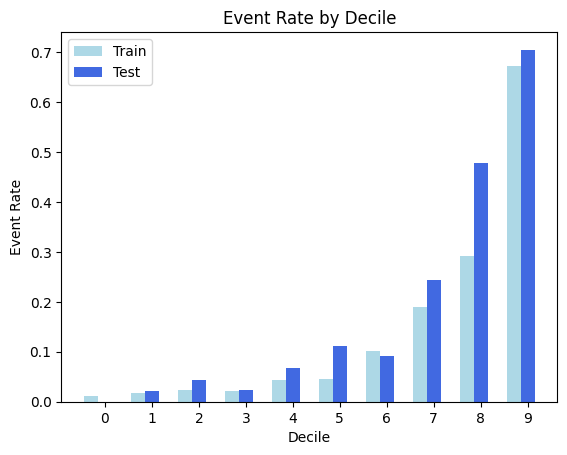

,Metric,Train Value,Test Value
0,KS,0.617050,0.621196
1,AUC,0.875371,0.874541
2,Gini,0.750742,0.749083


In [30]:
metrics, ord_score_train, ord_score_test = calculate_metrics(abt_train_t01, abt_teste_t01, 'Score_1', 'AceitouUltimaCampanha',bins=10)
metrics

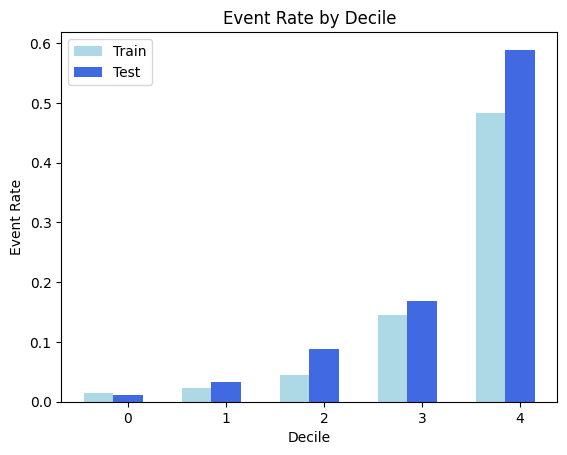

,Metric,Train Value,Test Value
0,KS,0.617050,0.621196
1,AUC,0.875371,0.874541
2,Gini,0.750742,0.749083


In [31]:
metrics, ord_score_train, ord_score_test = calculate_metrics(abt_train_t01, abt_teste_t01, 'Score_1', 'AceitouUltimaCampanha',bins=5)
metrics

In [32]:
ord_score_train

,decile,min_score,max_score,event_rate,volume
0,0,0.0000,0.0158,0.013850,361
1,1,0.0159,0.0376,0.022409,357
2,2,0.0377,0.0819,0.044693,358
3,3,0.0822,0.2120,0.145251,358
4,4,0.2132,0.9951,0.483240,358


In [33]:
ord_score_test

,decile,min_score,max_score,event_rate,volume
0,0,0.0010,0.0149,0.011111,90
1,1,0.0153,0.0369,0.033708,89
2,2,0.0372,0.0794,0.088889,90
3,3,0.0822,0.1956,0.168539,89
4,4,0.2042,0.9834,0.588889,90


In [34]:
abt_teste_t01.head()

,DiasDesdeUltimaCompra,AceitouCampanha3,TFT_EstadoCivil_3.0,AceitouCampanha5,AceitouCampanha1,TFT_NivelDeEducacao_3.0,TFT_GastoComOuroNosUltimos2Anos_1.0,TFT_EstadoCivil_2.0,TFT_VisitasAoSiteNoUltimoMes_1.0,AceitouCampanha4,...,TFT_GastoComDocesNosUltimos2Anos_2.0,TFT_GastoComDocesNosUltimos2Anos_1.0,TFE_QtdDeAdolescentesNaCasa,RendaAnualFamiliar,AceitouCampanha2,TFT_ComprasComDesconto_2.0,const,Score_1,Score_0,AceitouUltimaCampanha
670,81.0,0.0,0,0.0,0.0,1,0,0,0,0.0,...,1,0,1.0,59304.0,0.0,0,1.0,0.0153,0.9847,0
570,26.0,0.0,0,0.0,0.0,0,1,0,0,0.0,...,0,0,1.0,44989.0,0.0,1,1.0,0.0520,0.9480,0
39,53.0,1.0,0,0.0,0.0,1,1,1,0,0.0,...,1,0,0.0,48948.0,0.0,0,1.0,0.6919,0.3081,1
1909,95.0,1.0,0,0.0,0.0,0,1,0,0,0.0,...,0,0,0.0,31535.0,0.0,0,1.0,0.0520,0.9480,0
2231,71.0,0.0,1,0.0,0.0,0,1,0,1,0.0,...,0,0,0.0,44802.0,0.0,0,1.0,0.1079,0.8921,0


In [36]:
X_test.head()

,AnoDeNascimento,NivelDeEducacao,EstadoCivil,RendaAnualFamiliar,QtdDeCriancasNaCasa,QtdDeAdolescentesNaCasa,DiasDesdeUltimaCompra,GastoComVinhoNosUltimos2Anos,GastoComFrutasNosUltimos2Anos,GastoComCarneNosUltimos2Anos,...,ComprasNaLoja,VisitasAoSiteNoUltimoMes,AceitouCampanha3,AceitouCampanha4,AceitouCampanha5,AceitouCampanha1,AceitouCampanha2,ReclamouNosUltimos2Anos,IndicadorCustoContato,IndicadorDeReceita
670,1964,Doutorado,Casado(a),59304.0,0,1,81,418,61,428,...,10,5,0,0,0,0,0,0,3,11
570,1974,Graduação,Casado(a),44989.0,0,1,26,98,0,106,...,5,6,0,0,0,0,0,0,3,11
39,1943,Doutorado,Divorciado(a),48948.0,0,0,53,437,8,206,...,5,6,1,0,0,0,0,0,3,11
1909,1980,Mestrado,Casado(a),31535.0,1,0,95,15,4,13,...,2,7,1,0,0,0,0,0,3,11
2231,1970,Mestrado,Solteiro(a),44802.0,0,0,71,853,10,143,...,12,8,0,0,0,0,0,0,3,11


In [39]:
# Primeiro, unimos X_test e y_test com base no índice
df_combinado = X_test.join(y_test)

# Agora, adicionamos a coluna 'Score_1' do abt_teste_t01
df_combinado['Score_1'] = abt_teste_t01['Score_1']




In [40]:
df_combinado.head()

,AnoDeNascimento,NivelDeEducacao,EstadoCivil,RendaAnualFamiliar,QtdDeCriancasNaCasa,QtdDeAdolescentesNaCasa,DiasDesdeUltimaCompra,GastoComVinhoNosUltimos2Anos,GastoComFrutasNosUltimos2Anos,GastoComCarneNosUltimos2Anos,...,AceitouCampanha3,AceitouCampanha4,AceitouCampanha5,AceitouCampanha1,AceitouCampanha2,ReclamouNosUltimos2Anos,IndicadorCustoContato,IndicadorDeReceita,Score_1,AceitouUltimaCampanha
670,1964,Doutorado,Casado(a),59304.0,0,1,81,418,61,428,...,0,0,0,0,0,0,3,11,0.0153,0
570,1974,Graduação,Casado(a),44989.0,0,1,26,98,0,106,...,0,0,0,0,0,0,3,11,0.0520,0
39,1943,Doutorado,Divorciado(a),48948.0,0,0,53,437,8,206,...,1,0,0,0,0,0,3,11,0.6919,1
1909,1980,Mestrado,Casado(a),31535.0,1,0,95,15,4,13,...,1,0,0,0,0,0,3,11,0.0520,0
2231,1970,Mestrado,Solteiro(a),44802.0,0,0,71,853,10,143,...,0,0,0,0,0,0,3,11,0.1079,0


In [42]:
df_combinado.to_excel('df_estudo.xlsx')